<h1><center>ACEA Smart Water Analytics</center></h1>

## 1. Introduction 

This notebook presents a statistical anlysis of water data provided by the Italian multiutility operator group ACEA. The dataset comprises 4 different kinds of water bodies, namely aquifier, river, lake and spring. For each of these bodies, the aim is to understand and predict the behavior of given target variables that relates to the state of the water source (e.g. flow rate, groundwater level, hydrometry, etc.). The dataset also includes information about the local environment (e.g. precipitation, temperature, etc.), which may have a relevant link to the target variables, and hence assist in their prediction. 

The general strategy adopted in this work was to:
1. Clean the data, such that only reliable portions of the timeseries are taken into account
2. Pre-process the data in a way that makes physical sense, with the aim of both enhancing our understanding of the problem and helping with the prediction.
3. Develop machine learning models to predict the behviour of target variables, assess their performance over a range of scenarios, and report on the importance of each input feature in the prediction.

This work is structured as follows: 
- Section 2 presents a comprehensive analysis based on a single Aquifier dataset, demonstrating the approach and most of the techniques used throughout the notebook for other water datasets.  
- Sections 3, 4, and 5 provide a pared-down analysis for each other source type, namely lake, source and river, respectively. 
- Section 6 summarizes the main findings and provides suggestions for further analysis. 


The button below may be used to toggle the raw code on and off.

In [175]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [176]:
import pandas as pd
import numpy as np
# %matplotlib notebook
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pathlib import Path
from statsmodels.tsa.stattools import ccf
from scipy import stats

import math
from keras.models import Sequential
from keras.layers import InputLayer
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

plt.rcParams.update(plt.rcParamsDefault)
plt.style.use('seaborn-muted')
plt.rcParams['font.family'] = 'Arial'

# Fix random seed for reproducibility
np.random.seed(7)

In [177]:
# Preprocessing functions

def preprocess(df, col_ind, start_ind=0):
    """
    Some basic preprocessing of data from selected column of dataframe.
    This will probably need to be thought about more to deal with NaNs
    more effectively
    
    """
    pd_series = df.iloc[start_ind:, col_ind]
    pd_values = pd_series.to_numpy()
    # max_value = np.max(np.abs(pd_values))
    # pd_values = pd_values / max_value
    name = df.columns[col_ind]
    
    return pd_values, name


def preprocess_int(df, col_ind, start_ind=0, stop_ind=-1, fill_zeros=True):
    """
    Some basic preprocessing of data from selected column of dataframe.
    This will probably need to be thought about more to deal with NaNs
    more effectively
    
    """
    pd_series = df.iloc[start_ind:stop_ind, col_ind]
    pd_series = pd_series.astype('float32')
    if fill_zeros:
#         print(np.sum(np.isnan(pd_series.to_numpy())))
#         print('change_zero')
#         pd_series.replace(to_replace=0, value=np.nan)
        pd_series.mask(pd_series==0)
#         print(np.sum(np.isnan(pd_series.to_numpy())))
    pd_series = pd_series.interpolate(method='linear')
    pd_series = pd_series.fillna(method='bfill')
    pd_series = pd_series.fillna(method='ffill')
    pd_values = pd_series.to_numpy()
    # max_value = np.max(np.abs(pd_values))
    # pd_values = pd_values / max_value
    name = df.columns[col_ind]
    
    return pd_values, name


def get_time_series(col_inds, start_ind=0, stop_ind=-1, fill_zeros=True):
    """
    Get all of the time series from the specified column indices and their names
    and populate lists for each
    
    """
    ts = []
    name = []
    
    for n in range(len(col_inds)):
        ts_, name_ = preprocess_int(df, col_inds[n], start_ind=start_ind, stop_ind=stop_ind, fill_zeros=fill_zeros)
        ts.append(ts_)
        name.append(name_)
        
    return ts, name


def find_data_gaps(dataframe, plot=True, title=None):
    """
    Finds NaNs and zeros in dataframe, with optional plot to show their locations
    
    """
    # Put dataframe into numpy array, ignoring date variable
    df_nodate = df.drop(['Date'], axis=1)
    all_data = df_nodate.to_numpy(na_value=np.nan)
    col_names = df_nodate.columns
    numcol = len(col_names)

    # Find missing values
    is_nan = np.isnan(all_data)
    is_zero = (all_data == 0)
    nan_array = np.where(is_nan, 1, np.nan)
    zero_array = np.where(is_zero, 1, np.nan)

    # Plot showing missing values and zeros
    if plot:
        if title is None: title = 'Location of NaNs and zeros in dataset'
        fig = plt.figure(figsize=(9, 5))
        ax = plt.subplot(111)
        # divider = make_axes_locatable(ax)
        # cax = divider.append_axes("top", size="5%", pad=0.08)
        norm = mpl.colors.Normalize(vmin=-1, vmax=1)
        sc_map = mpl.cm.ScalarMappable(norm=norm, cmap='PiYG')
        ms = ax.imshow(nan_array.T, aspect='auto', cmap='Pastel1', interpolation='none')
        ms2 = ax.imshow(zero_array.T, aspect='auto', cmap='Set3', interpolation='none')
        ax.set_yticks(np.arange(numcol))
        ax.set_yticklabels(col_names)
        ax.set_xlabel('Time [days]')
        cmap_nan = plt.cm.Pastel1
        cmap_zero = plt.cm.Set3
        custom_lines = [Line2D([0], [0], color=cmap_zero(0.), lw=5),
                        Line2D([0], [0], color=cmap_nan(0.), lw=5)]
        ax.legend(custom_lines, ['Zero', 'NaN'], loc='lower right')
        plt.title(title)
        plt.tight_layout()
        plt.show()
    
    return all_data, col_names, is_nan, is_zero


def normalise_sum(signal):
    """
    Normalises a signal so that the sum of all samples is unity.

    :param signal: An array of values representing the signal to be normalised.
    :returns: An array of values representing the normalised signal.

    """
    signal = np.asarray(signal, dtype=float)
    sum_ = np.sum(signal) if signal.any() else 1.

    return signal / sum_


def movingav(signal, winwidth, winfunc=None):
    """
    Calculates the moving average of a signal using chosen window function.

    :param signal: An array of values representing the signal to be smoothed.
    :param winwidth: The width of the smoothing window (number of samples).
    :param winfunc: The window function to use for smoothing. By default, a
        rectangular window will be used.
    :returns: An array of values representing the smoothed signal.
    :raises ValueError: If window width is negative.
    :raises ValueError: If window width exceeds length of input array.

    """
    numsamples = len(signal)

    hww = int(winwidth / 2.)
    winwidth = 2 * hww + 1

    if winwidth < 0:
        raise ValueError("window width must not be negative")

    if winwidth >= numsamples:
        raise ValueError("window width must not exceed length of input array")

    win = np.ones(winwidth) if winfunc is None else winfunc(winwidth)

    win = normalise_sum(win)

    halfwin2 = normalise_sum(win[hww:])
    halfwin1 = normalise_sum(win[:hww+1])

    valstart = np.dot(halfwin2, signal[0:hww+1])
    valend = np.dot(halfwin1, signal[numsamples - hww - 1:])

    signal = np.concatenate((np.ones(hww) * valstart, signal,
                             np.ones(hww) * valend))

    wpos = hww
    wend = len(signal) - hww - 1

    sig_smooth = np.empty(numsamples)

    while wpos <= wend:
        sig_smooth[wpos - hww] = np.dot(signal[wpos-hww: wpos+hww+1], win)
        wpos += 1

    return sig_smooth

In [178]:
# Statistical functions 

def spearman_lag(data1, data2, lag):
    """Calculate Spearman's rank correlation coefficient between 2 datasets,
    with a lag applied to data2"""
    
    data_length = data1.size
    if lag > 0:
        data2_lag = np.zeros(data_length)
        data2_lag[lag:] = data2[:-lag] 
        data2_lag[:lag] = data2[0]
    else:
        data2_lag = data2
    src, _ = stats.spearmanr(data1, data2_lag)
    
    return src


def cross_corr_lag(data1, data2, lag_array=None):
    """Calculate Spearman's rank correlation coefficient between 2 datasets,
    for a range of different lags applied to data2"""
    if lag_array is None:
        lag_array = np.arange(data1.size)
    crosscorr_lag = np.empty(len(lag_array))
    for n in range(len(lag_array)):
        crosscorr_lag[n] = spearman_lag(data1, data2, lag=lag_array[n])
        
    return crosscorr_lag, lag_array


def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w


def normalise_0_to_1(signal):
#     signal = np.asarray(signal)
    sig_min = np.min(signal)
    sig_max = np.max(signal)
    sig_norm = (signal - sig_min) / (sig_max - sig_min)
    return sig_norm


def exp_convolve(data, tau, winlength=None):
    """
    Convolve input data with an exponential window function (time constant = tau)
    
    """
    data = np.asarray(data)
    len_data = data.size
    if winlength is None:
        winlength = len_data
    t = np.linspace(0, winlength-1, winlength)
    exp_window = np.exp(-t / tau)
    exp_window = exp_window / np.sum(exp_window)
    data_conv = np.convolve(data, exp_window, 'full')[:len_data]

    return data_conv


def find_datatypes(df):
    """Find the indices of each pf the different datatypes in the dataframe"""
    names = df.columns
    datatypes = ['Rainfall',
                 'Depth_to_Groundwater',
                 'Temperature',
                 'Volume',
                 'Hydrometry',
                 'Flow_Rate',
                 'Lake_Level']
    col_inds = []
    
    for n in range(len(datatypes)):
        col_ind_type = []
        for c in range(len(names)):
            if datatypes[n] in names[c]:
                col_ind_type.append(c)
        col_inds.append(col_ind_type)
        
    return datatypes, col_inds

In [179]:
# Plotting functions 

def plot_data_preprocessed(df, col_ind):
    data_ts, _ = preprocess(df, col_ind)
    data_ts_int, _ = preprocess_int(df, col_ind)
    data_ts_size = data_ts.size
    data_ts_int_size = data_ts_int.size
    time_array = np.linspace(0, data_ts_size-1, data_ts_size)
    time_array2 = np.linspace(0, data_ts_int_size-1, data_ts_int_size)
    plt.figure()
    plt.scatter(time_array, data_ts, s=0.2, alpha=0.6)
    plt.scatter(time_array2, data_ts_int, s=0.2, alpha=0.6)
    plt.show()
    

def plot_preprocessing(input_raw, input_pp, input_name, target_ts, target_name,
                       crop_min=1600, crop_max=2000, title=None):
    """
    Plot raw data and preprocessed data compared to target variable
    
    """
    cmap = plt.get_cmap('Dark2')
    colors = [cmap(i) for i in np.linspace(0, 1, 8)]
    len_data = input_raw.size
    fig, ax = plt.subplots(3, 2, sharey=True, figsize=(9, 4))
    y_max = 1.2
    
    ax[1, 0].set_ylim(0, y_max)
    ax[0, 0].plot(normalise_0_to_1(input_raw), color=colors[0], alpha=0.8)
    ax[1, 0].plot(normalise_0_to_1(input_pp), color=colors[1], alpha=0.8)
    ax[2, 0].plot(normalise_0_to_1(target_ts), color=colors[2], alpha=0.8)
    label1 = '{}, raw data'.format(input_name)
    label2 = '{}, pre-processed'.format(input_name)
    label3 = target_name
    ax[0, 1].text(0.01, 0.95, label1, transform=ax[0, 1].transAxes, va='top', ha='left')
    ax[1, 1].text(0.01, 0.95, label2, transform=ax[1, 1].transAxes, va='top', ha='left')
    ax[2, 1].text(0.01, 0.95, label3, transform=ax[2, 1].transAxes, va='top', ha='left')
    
    xmin = crop_min
    xmax = crop_max
    for n in range(3):
        ax[n, 0].plot([xmin, xmin], [0, y_max], 'k--', alpha=0.6)
        ax[n, 0].plot([xmax, xmax], [0, y_max], 'k--', alpha=0.6)
        ax[n, 0].set_xlim(0, len_data)
        ax[n, 1].set_xlim(xmin, xmax)
        con = mpl.patches.ConnectionPatch(xyA=[len_data, y_max/2], coordsA=ax[n, 0].transData,
                                          xyB=[xmin, y_max/2], coordsB=ax[n, 1].transData,
                                          arrowstyle='->')
        fig.add_artist(con)
        
    days = np.arange(xmin, xmax) 
    ax[0, 1].plot(days, normalise_0_to_1(input_raw)[xmin: xmax], color=colors[0], alpha=0.8)
    ax[1, 1].plot(days, normalise_0_to_1(input_pp)[xmin: xmax], color=colors[1], alpha=0.8)
    ax[2, 1].plot(days, normalise_0_to_1(target_ts)[xmin: xmax], color=colors[2], alpha=0.8)
    
    for n in range(2):
        ax[n, 0].axes.xaxis.set_ticklabels([])
        ax[n, 1].axes.xaxis.set_ticklabels([])
        ax[2, n].set_xlabel('Time [days]')
        
    if title is None:
        title = input_name + ' raw and pre-processed data, compared to ' + target_name
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()
    
    return


def plot_correl_matrix(data, names, title=None):
    """
    Plot cross-correlation matrix for input data, using Spearman's rank
    data should have shape: (num variables, num samples)
    names should be list of length (num variables)
    
    """
    # Calculate cross-correlation
    cross_corr, p_value = stats.spearmanr(data.T, nan_policy='omit')
    
    # Plot results
    numdata = len(names)
    if title is None:
        title = 'Cross-correlation matrix'
    fig = plt.figure(figsize=(9, 9))
    ax = plt.subplot(111)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.08)
    norm = mpl.colors.Normalize(vmin=-1, vmax=1)
    sc_map = mpl.cm.ScalarMappable(norm=norm, cmap='PiYG')
    ms = ax.imshow(cross_corr, cmap='PiYG', interpolation='none', vmin=-1, vmax=1)
    fig.suptitle(title)
    ax.set_xticks(np.arange(numdata))
    ax.set_yticks(np.arange(numdata))
    ax.set_xticklabels(names)
    ax.set_yticklabels(names)
    ax.xaxis.set_ticks_position('bottom')
    plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
             rotation_mode="anchor")
    plt.colorbar(mappable=sc_map, cax=cax)
    plt.tight_layout()
    plt.show()
      
    return


In [180]:
# tau analysis functions 

def find_tau_correlation(target_ts, rain_ts, tau_array=None):
    """
    Calculate convolution of rainfall data with an exponential window
    with time constant tau, for a range of values of tau.
    Then determine how correlated these convolved signals are to the
    target data by calculating Spearman's rank correlation coefficient
    for each value of tau
    
    """
    if tau_array is None:
        tau_array = np.linspace(2, 120, 60)
        
    rain_ts = np.asarray(rain_ts)
    target_ts = np.asarray(target_ts)
    winlength = rain_ts.size
    target_len = target_ts.size
    
    t = np.linspace(0, winlength-1, winlength)
    src = np.empty(len(tau_array))
    
    for n in range(len(tau_array)):
        exp_win = np.exp(-t/tau_array[n])
        rain_conv = np.convolve(rain_ts, exp_win, 'full')[:target_len]
        rain_conv = rain_conv / np.sum(exp_win)
        # if n==40:
        #     plt.figure()
        #     plt.plot(rain_ts, label='rain_ts')
        #     plt.plot(rain_conv, label='rain_conv')
        #     plt.plot(target_ts, label='target_ts')
        #     plt.legend()
        #     plt.show()
        src[n], _ = stats.spearmanr(target_ts, rain_conv)
        
    return src, tau_array


def find_best_tau(target_ts, rain_ts, plot=True, rain_name=None, target_name=None, tau_array=None):
    """
    Calculate correlation of convolved rainfall signal with the
    target signal for different time constants of exponential window
    and select the tau value that gives the best correlation.
    Optional plot of correlation for different tau values.
    
    """
    tau_best = []
    src_best = []
    if plot: plt.figure()
    for n in range(len(rain_ts)):
        src, tau_array = find_tau_correlation(
                                normalise_0_to_1(target_ts),
                                normalise_0_to_1(rain_ts[n]),
                                tau_array=tau_array)
        tau_best.append(tau_array[np.argmax(src)])
        src_best.append(src[np.argmax(src)])
        if plot: plt.plot(tau_array, src, label=rain_name[n], lw=1.5, alpha=0.7)  
            
    if plot:
        plt.xlabel("Time constant (tau) for convolution with exponential window")
        plt.ylabel("Spearman's Rank correlation coefficient")
        title_text = 'Correlation of convolved rainfall data with {} for different tau values'.format(target_name)
        plt.title(title_text, wrap=True)
        min_corr = np.min(src)
        if min_corr < 0:
            plt.ylim(min_corr, 1)
        else:
            plt.ylim(0, 1)
        plt.legend(fontsize=9)
        plt.tight_layout()
        plt.show()
        
    return tau_best, src_best


def find_all_best_tau(input_ts, input_name, target_ts, target_name, tau_array=None,
                      target_0_tau_array=None):
    """
    Calculating optimum tau for each input/target combination that
    maximises the Spearman's Rank correlation coefficient when the input is
    convolved with an exponential window (time constant tau)
    
    """
    # Find best tau values
    all_tau_best = []
    all_src_best = []
    for n in range(len(target_ts)):
        if n == 0 and target_0_tau_array is not None:
            tau_ = target_0_tau_array
        else:
            tau_ = tau_array
        tau_best, src_best = find_best_tau(target_ts[n], input_ts, plot=False,
                                           tau_array=tau_)
        all_tau_best.append(tau_best)
        all_src_best.append(src_best)
    all_tau_best = np.asarray(all_tau_best)
    all_src_best = np.asarray(all_src_best)

    # Plot results
    fig = plt.figure()
    ax = plt.subplot(111)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size=0.3, pad=0.08)
#     cbar_min = np.min(all_tau_best)
#     cbar_max = np.max(all_tau_best[1:, :]) + 5
    cbar_min = 0
    cbar_max = 1
    norm = mpl.colors.Normalize(vmin=cbar_min, vmax=cbar_max)
    sc_map = mpl.cm.ScalarMappable(norm=norm, cmap='viridis')
    ms = ax.imshow(all_src_best, norm=norm, cmap='viridis')
    for i in range(len(target_name)):
        for j in range(len(input_name)):
            if (cbar_max - all_tau_best[i, j]) / (cbar_max - cbar_min) < 0.2:
                text_col = 'k'
            else:
                text_col = 'w'
            text = ax.text(j, i, np.int(all_tau_best[i, j]),
                           ha="center", va="center", color=text_col,
                           fontsize=8)
    fig.suptitle('Correlation of convolved rainfall with target, for optimum tau values')
    ax.set_xticks(np.arange(len(input_name)))
    ax.set_yticks(np.arange(len(target_name)))
    ax.set_xticklabels(input_name)
    ax.set_yticklabels(target_name)
    ax.xaxis.set_ticks_position('bottom')
    plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
             rotation_mode="anchor")
#     plt.colorbar(mappable=sc_map, cax=cax, extend='max')
    plt.colorbar(mappable=sc_map, cax=cax)
    plt.tight_layout()
    plt.show()

    return all_tau_best


def tau_and_lag_correl(target_ts, rain_ts, lag_array=None, tau_array=None,
                       plot=True):
    """
    Calculate correlation coefficients for different time lag and tau
    values for rainfall. Optional plot.

    """
    # Set default lag and tau values to analyse
    if lag_array is None:
        lag_array = np.arange(20)
    if tau_array is None:
        tau_array = np.linspace(22, 90, 35).astype(np.int)
        
    # Calculate Spearman's Rank coefficient for each tau and lag combination
    sp_rank_cc = []
    for n in range(len(lag_array)):
        lag = lag_array[n]
        data_length = rain_ts.size
        if lag > 0:
            data_lag = np.zeros(data_length)
            data_lag[lag:] = rain_ts[:-lag]
            data_lag[:lag] = rain_ts[0]
        else:
            data_lag = rain_ts
        src, _ = find_tau_correlation(target_ts, data_lag,
                                      tau_array=tau_array)
        sp_rank_cc.append(src)
    sp_rank_cc = np.asarray(sp_rank_cc)
    
    # Plot matrix showing correlation for each tau and lag combination
    if plot:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(sp_rank_cc)
        fig.colorbar(cax)
        ax.set_xticks(np.arange(len(tau_array)))
        ax.set_yticks(np.arange(len(lag_array)))
        ax.set_xticklabels(tau_array)
        ax.set_yticklabels(lag_array)
        ax.xaxis.set_ticks_position('bottom')
        plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
                 rotation_mode="anchor")
        ax.set_xlabel('Tau for exponential window')
        ax.set_ylabel('Time lag [days]')
        plt.title('Correlation of rainfall with target for different values of tau and time lag')
        fig.show()
        
    return sp_rank_cc, lag_array, tau_array

In [181]:
# Volume pre-processing

def preprocess_vol(vol_data, smooth_amt_1=800, smooth_amt_2=30):
    """Pre-process volume data by smoothing, calculating deviation from the smoothed data,
    and then smoothing again"""
    deviation = vol_data - movingav(vol_data, smooth_amt_1, winfunc=np.hanning)
    smoothed = movingav(deviation, smooth_amt_2, winfunc=np.hanning)
    return normalise_0_to_1(smoothed)
    

def find_best_vol_params(vol_ts, target_ts, smoothing_1=None, smoothing_2=None, plot=True):
    """Calculate the correlation of the preprocessed volume data with the target data for
    different lengths of smoothing window, in order to find the most appropropriate settings"""
    if smoothing_1 is None:
        smoothing_1 = np.linspace(50, 2000, 40).astype(np.int)
    if smoothing_2 is None:
        smoothing_2 = np.linspace(2, 40, 20).astype(np.int)
    num_smth_1 = smoothing_1.size
    num_smth_2 = smoothing_2.size
    coeffs = np.empty((num_smth_1, num_smth_2))
    for i in range(num_smth_1):
        for j in range(num_smth_2):
            vol_processed = preprocess_vol(vol_ts, smooth_amt_1=smoothing_1[i],
                                           smooth_amt_2=smoothing_2[j])
            corr_coeff, _ = stats.spearmanr(vol_processed, target_ts)
            coeffs[i, j] = corr_coeff
    
    if plot:
        plt.figure()
        ax = plt.subplot(111)
        im = ax.imshow(coeffs.T)
#         norm = mpl.colors.Normalize(vmin=0, vmax=1)
#         sc_map = mpl.cm.ScalarMappable(norm=norm, cmap='viridis')
#         plt.colorbar(mappable=sc_map)
        ax.figure.colorbar(im, ax=ax)
        ax.set_xticks(np.arange(num_smth_1))
        ax.set_yticks(np.arange(num_smth_2))
        ax.set_xticklabels(smoothing_1)
        ax.set_yticklabels(smoothing_2)
        ax.xaxis.set_ticks_position('bottom')
        plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
                 rotation_mode="anchor")
        plt.show()
        
    return


In [182]:
# Modelling functions 


def run_model(target_data, input_data, model_type='LSTM', use_target=True, look_back=30,
              chunk_step=50, train_ratio=0.67, num_epochs=30, batch_size=5, predict_steps=15,
              plot=True, verbose=0, MLP_layers=None, print_score=False):
    """
    Wrapper function for machine learning model
    
    model_type defines which machine learning model to use:
        - If model_type is 'MLP', model will be a multi-layer perceptron model.
        - Otherwise (e.g. for default value 'LSTM'), model will be an LSTM model.
    
    """
    # Normalize the target dataset
    target_data = np.reshape(target_data, (target_data.size, 1))
    scaler = MinMaxScaler(feature_range=(0, 1))
    target_scaled = scaler.fit_transform(target_data)
    target_scaled = np.squeeze(target_scaled)

    # Normalise the input variables
    num_input = model_input_data.shape[0]
    input_data_scaled = np.empty(input_data.shape)
    for n in range(num_input):
        input_data_scaled[n, :] = normalise_0_to_1(input_data[n, :])

    # Combine target and inputs into single array
    num_timesteps = target_data.size
    model_data = np.empty((num_input + 1, num_timesteps))
    model_data[0, :] = target_scaled
    model_data[1:, :] = input_data_scaled
#     print('Model_data shape: {}'.format(model_data.shape))

    # Plot preprocessed data
    if plot:
        plt.figure(figsize=(8, 3))
        plt.plot(model_data[0, :], label=target_name[target_ind])
        plt.plot(model_data[1, :], label='input')
        plt.legend()
        plt.title('Preprocessed data')
        plt.show()

    # Split data into chunks with random order
    x, y, y_ind = create_dataset(model_data, use_target=use_target, look_back=look_back,
                                 chunk_step=chunk_step, predict_steps=predict_steps)
    numchunk = y.shape[0]
#     print('x shape: {}'.format(x.shape))
#     print('y shape: {}'.format(y.shape))

    # split into train and test sets
    train_size = int(numchunk * train_ratio)
    test_size = numchunk - train_size
    trainX, testX = x[0:train_size, :, :], x[train_size:numchunk, :, :]
    trainY, testY = y[0:train_size, :], y[train_size:numchunk, :]
    trainYind, testYind = y_ind[0:train_size], y_ind[train_size:numchunk]
    
    # Plot one example of chunk
    if plot:
        sample_num = 0
        plt.figure(figsize=(8, 3))
        time_ = np.arange(look_back)
        plt.plot(time_, trainX[sample_num, :, 0], label='Input: target')
        plt.plot(time_, trainX[sample_num, :, 1], label='Input: rain')
        plt.plot([look_back], trainY[sample_num, 0], 'xr', label='Output: target')
        plt.legend()
        plt.title("Example of one chunk from dataset")
        plt.show()

    # create and fit the LSTM network
    num_features = x.shape[2]
    
    if model_type == 'MLP':
        # flatten inputs for MLP model
        n_input = x.shape[1] * x.shape[2]
        trainX = trainX.reshape((trainX.shape[0], n_input))
        testX = testX.reshape((testX.shape[0], n_input))
    
    model = Sequential()
    
    if model_type == 'MLP':
        model.add(InputLayer(input_shape=(n_input, )))
        if MLP_layers is not None:
            for n in range(len(MLP_layers)):
                model.add(Dense(MLP_layers[n], activation='relu'))
        else:
            model.add(Dense(500, activation='relu'))
            model.add(Dense(100, activation='relu'))
    else:
        model.add(InputLayer(input_shape=(look_back, num_features)))
        model.add(LSTM(4))
    model.add(Dense(predict_steps))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainX, trainY, epochs=num_epochs, batch_size=batch_size, verbose=verbose)

    # make predictions
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)

    # invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform(trainY)
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform(testY)

    # calculate RMSE and MSE
    trainRMSE = mean_squared_error(trainY, trainPredict, multioutput='raw_values', squared=False)
    testRMSE = mean_squared_error(testY, testPredict, multioutput='raw_values', squared=False)
    trainMSE = mean_squared_error(trainY, trainPredict, multioutput='raw_values', squared=True)
    testMSE = mean_squared_error(testY, testPredict, multioutput='raw_values', squared=True)
    
    # Print RMSE scores
    if print_score:
        print('Train Score: %.2f RMSE' % (trainRMSE[0]))
        print('Test Score: %.2f RMSE' % (testRMSE[0]))
    
    return model, trainRMSE, testRMSE, trainMSE, testMSE, testYind, testPredict, \
            trainYind, trainPredict


class ML_model(object):
    """
    Stores a set of input data, target data, hyperparams and results for machine learning model.

    """
    def __init__(self, target_data, input_data, use_target=True, look_back=30,
                 chunk_step=50, train_ratio=0.67, num_epochs=30, batch_size=5,
                 predict_steps=15, plot=False, verbose=0):
        """
        Initialise ML_model object
        target_data: output variable for model, should have shape (num_timesteps)
        input_data: input data for model, should have shape (numfeatures, num_timesteps)
        use_target: if True, target variable will be used as an input, otherwise it will be excluded
        look_back: number of timesteps behind output that the model will use
        chunk_step: the spacing between chunks of input data (smaller number means more chunks)
        train_ratio: proportion of total chunks that are used to train the model
        num_epochs: Number of epochs in the model training
        batch_size: batch size for the model training
        predict_steps: number of timesteps that the model will predict ahead of input data
        plot: if True, plots illustrating model will be shown
        verbose: defines how much info on model training is output (can be 0, 1 or 2)
        
        """
        self.target_data = target_data
        self.input_data = input_data
        self.use_target = use_target
        self.look_back = look_back
        self.chunk_step = chunk_step
        self.train_ratio = train_ratio
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.predict_steps = predict_steps
        self.model_plot = plot
        self.verbose = verbose

    def run(self, model_type='LSTM', print_score=False):
        """
        Creates and runs a model, of the type specified by 'model_type':
          - If model_type is 'MLP', model will be a multi-layer perceptron model.
          - Otherwise (e.g. for default value 'LSTM'), model will be an LSTM model.        
        Outputs are stored in class variables:
        self.trainRMSE: RMSE score for predictions from training data
        self.testRMSE: RMSE score for predictions from test data
        self.testYind: timestep indices of the prediction from test chunks
        self.trainYind: timestep indices of the prediction from training chunks
        self.testPredict: Predictions from test data
        self.trainPredict: Predictions from training data
        """
        self.model_type = model_type
        self.model, self.trainRMSE, self.testRMSE, self.trainMSE, \
        self.testMSE, self.testYind, self.testPredict, \
        self.trainYind, self.trainPredict = run_model(target_data=self.target_data,
                                                      input_data=self.input_data,
                                                      model_type=self.model_type,
                                                      use_target=self.use_target,
                                                      look_back=self.look_back,
                                                      chunk_step=self.chunk_step,
                                                      train_ratio=self.train_ratio,
                                                      num_epochs=self.num_epochs,
                                                      batch_size=self.batch_size,
                                                      predict_steps=self.predict_steps,
                                                      plot=self.model_plot,
                                                      verbose=self.verbose,
                                                      print_score=print_score)
        
        self.weights = []
        for n in range(len(self.model.layers)):
            self.weights.append(self.model.layers[n].get_weights()[0])
            
        return

    
    def plot_predict_one_step(self, crop_min=None, crop_max=None, title=None):
        """
        Plot predictions from test and training samples against original data,
        for first timestep prediction only (i.e. no lookahead)
        x-axis (time) can be cropped to between 'crop_min' and 'crop_max' to show
        a particular time range if desired.
        
        """
        if title == None:
            title = "Predictions (single timestep) compared to original dataset"
        
        
        plt.figure(figsize=(9, 4))
        plt.plot(np.linspace(0, self.target_data.size-1, self.target_data.size),
                 self.target_data,
                 label='Original data')
        plt.plot(self.testYind, self.testPredict[:, 0], 'xr', markeredgewidth=0.8,
                 markersize=4, markeredgecolor=[0.9, 0.2, 0.2, 0.8],
                 label='Test predictions')
        plt.plot(self.trainYind, self.trainPredict[:, 0], 'xg', markeredgewidth=0.8,
                 markersize=4, markeredgecolor=[0.2, 0.7, 0.3, 0.8],
                 label='Train predictions')
        plt.legend()
        plt.title(title)
        if crop_min is not None and crop_max is not None:
            plt.xlim(crop_min, crop_max)
        plt.show()
        
        return

    
    def plot_predict_all_steps(self, crop_min=None, crop_max=None):
        """
        Plot predictions from test and training samples against original data,
        for all timesteps of prediction (i.e. with lookahead)
        x-axis (time) can be cropped to between 'crop_min' and 'crop_max' to show
        a particular time range if desired.
        
        """        
        plt.figure(figsize=(9, 4))
        plt.plot(np.linspace(0, self.target_data.size-1, self.target_data.size),
                 self.target_data,
                 label='Original data')
        for n in range(len(self.testYind)):
            if n == 0:
                plt.plot(np.arange(self.testYind[n], self.testYind[n] + self.predict_steps),
                         self.testPredict[n, :], '-r', lw=1, color=[0.9, 0.2, 0.2, 0.8], label='Test predictions')
            else:
                plt.plot(np.arange(self.testYind[n], self.testYind[n] + self.predict_steps),
                         self.testPredict[n, :], '-r', lw=1, color=[0.9, 0.2, 0.2, 0.8])
        for n in range(len(self.trainYind)):
            if n == 0:
                plt.plot(np.arange(self.trainYind[n], self.trainYind[n] + self.predict_steps),
                         self.trainPredict[n, :], '-g', lw=1, color=[0.2, 0.7, 0.3, 0.8], label='Train predictions')
            else:
                plt.plot(np.arange(self.trainYind[n], self.trainYind[n] + self.predict_steps),
                         self.trainPredict[n, :], '-g', lw=1, color=[0.2, 0.7, 0.3, 0.8])
        plt.legend()
        plt.title("Predictions (all timesteps) compared to original dataset")
        if crop_min is not None and crop_max is not None:
            plt.xlim(crop_min, crop_max)
        plt.show()
        
        return
    
        
    def plot_weights(self, feature_names):
        """
        Plot weights matrix
        
        """
        layer_1_mean = np.mean(self.weights[0], axis=1)
        if self.use_target:
            layer_1_mean = layer_1_mean.reshape((self.look_back, self.input_data.shape[0] + 1))
        else:
            layer_1_mean = layer_1_mean.reshape((self.look_back, self.input_data.shape[0]))
            
        plt.figure()
        ax = plt.subplot(111)
        im = ax.imshow(layer_1_mean.T)
        ax.set_yticks(np.arange(len(feature_names)))
        ax.set_xticks(np.arange(self.look_back))
        ax.set_yticklabels(feature_names)
        ax.set_xticklabels(np.linspace(-self.look_back, -1, self.look_back).astype(np.int))
        ax.xaxis.set_ticks_position('bottom')
        plt.setp(ax.get_xticklabels()[::2], visible=False)
        plt.setp(ax.get_yticklabels(), ha="right")
        ax.set_title("First model layer: average weights")
        ax.set_xlabel('Input sample timestep before prediction [days]')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", "5%", pad="5%")
        plt.colorbar(im, cax=cax)
        plt.show()
        
        return
    

def compile_model_input_variables(model_rain_ind,
                                  model_vol_ind,
                                  model_temp_ind,
                                  model_hydro_ind,
                                  rain_pp,
                                  vol_pp,
                                  temp_pp,
                                  hydro_pp,
                                  num_timesteps):
    """
    Extract the selected variables from the preprocessed data by their indices
    and populate an input array to be used by the model.
    The input array will have shape: (num features, num timesteps)
    
    """    
    num_inputs = len(model_rain_ind) + len(model_vol_ind) + \
                 len(model_temp_ind) + len(model_hydro_ind)
    model_input_data = np.empty((num_inputs, num_timesteps))
    count = 0
    for i in model_rain_ind:
        model_input_data[count, :] = rain_pp[i]
        count += 1
    for i in model_vol_ind:
        model_input_data[count, :] = vol_pp[i]
        count += 1
    for i in model_temp_ind:
        model_input_data[count, :] = temp_pp[i]
        count += 1
    for i in model_hydro_ind:
        print()
        model_input_data[count, :] = hydro_pp[i]
        count += 1
    
    return model_input_data


def create_dataset(dataset, look_back=1, chunk_step=1, predict_steps=1, use_target=True):
    """
    Convert data set into a dataset matrix by splitting the data into a number of 'chunks'
    that are randomly ordered. Each chunk has an input (x) of length 'look_back', and an
    output (y) of length 'predict_steps'. The indices of each chunk within the original array
    are stored in 'y_ind'.
    The target should be the first feature in the dataset.
    If 'use_target' is True, the target will be used as an input (i.e. will be part of x),
    otherwise it will be excluded from x and only used in y.
    The shape of the input and output arrays is as follows:
    dataset: (num features, num timesteps)
    x:       (num chunks, look_back, num features)
    y:       (num chunks, predict_steps)
    y_ind:   (num chunks)
    
    """
    numchunk = int(np.floor((dataset.shape[1] - look_back - predict_steps - 1) / chunk_step))
    if use_target:
        dataX = np.empty((numchunk, look_back, dataset.shape[0]))
    else:
        if dataset.shape[0] == 1:
            print('No input data in dataset, try adding features or setting use_target=True')
        dataX = np.empty((numchunk, look_back, dataset.shape[0] - 1))
    dataY = np.empty((numchunk, predict_steps))
    y_ind = []
    
    # Create chunks of data with the specified look back
    for i in range(numchunk):
        start_ind = chunk_step*i
        if use_target:
            dataX[i, :, :] = dataset[:, start_ind:(start_ind + look_back)].T
        else:
            dataX[i, :, :] = dataset[1:, start_ind:(start_ind + look_back)].T
        dataY[i, :] = dataset[0, start_ind+look_back:start_ind+look_back+predict_steps] #MG
        #dataY.append(dataset[0, start_ind + look_back])
        y_ind.append(start_ind + look_back)
        
    # Randomise order of chunks
    rand_indices = np.random.permutation(numchunk)
    x = np.array(dataX)
    y = np.array(dataY)
    y_ind = np.array(y_ind)
    x = x[rand_indices, :]
    y = y[rand_indices,:]
    #y = np.reshape(y, (y.size, 1)) # MG
    y_ind = y_ind[rand_indices]
    
    return x, y, y_ind


# 2. Base analysis: Aquifier Auser
## 2.1 Data pre-processing
### 2.1.1 Handling missing data

First, the data was read in and an analysis of missing data was carried out. The plot below shows that there is a significant amount of data missing over the total time period, either in the form of NaNs, or zeros. In the case of the rainfall data, the zeros are considered to be 'real data' since there are many days with zero rainfall, however for the other data it is assumed that zeros imply missing data.

When deciding how to handle these gaps in the data, the aim was to find a compromise between maintaining as much of the original data as possible, and not introducing too much inaccuracy from filling in the gaps. For each variable, we consider a combination of three different options for handling these gaps:
1. Crop the entire dataset over a certain time range to avoid the gaps. If many of the variables contain missing data for the same time period, then this option is sensible as this time period is unlikely to be useful for the model.
2. Remove the variable completely. This may be necessary if there is missing data for large time periods, particularly if many other variables contain data in those time periods. For example, 'Volume_CSA' and 'Volume CSAL' both contain large gaps in the data where there is data for most other variables (from days ~3000-6000, so it makes sense to remove these from the analysis.
3. Fill in the missing data for that variable by prediction (e.g. interpolation, backpropagation). Where the gaps in the data are relatively short and make up a small proportion of the total data, this option is likely to be preferable.

Since there are NaNs in most of the data for the first ~3000 days, including all of the target variables, it was decided that this time period would not be used for the model at all.

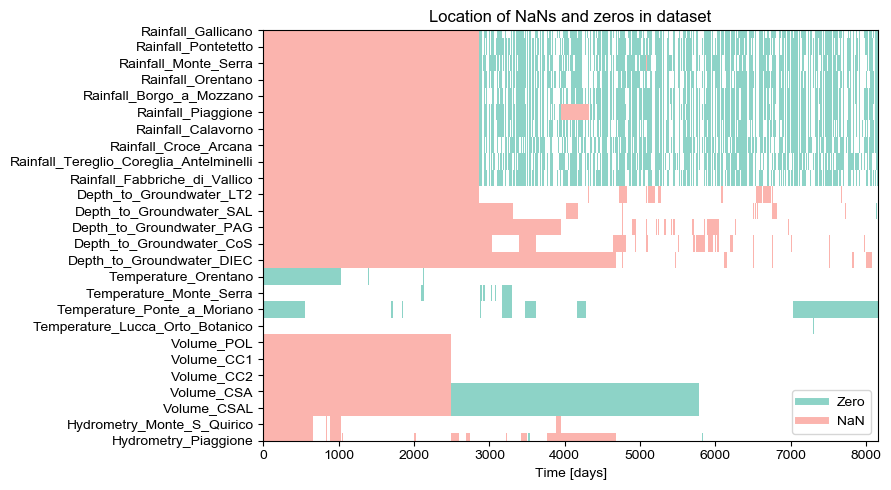

In [183]:
# Pre-processing data

# Importing all data into pandas dataframe
foldpath = r"acea-water-prediction"
files = sorted(list(Path(foldpath).rglob('*.csv')))
df = pd.read_csv(files[0])

# Find and plot gaps in the data
all_data, col_names, is_nan, is_zero = find_data_gaps(df, plot=True, title=None)


In [184]:
# Find column indices for different datatypes
datatypes, col_inds = find_datatypes(df)

# Get time series data for all variable types
start_ind = 3955
rain_ts, rain_name = get_time_series(col_inds[0], start_ind=start_ind, fill_zeros=False)
target_ts, target_name = get_time_series(col_inds[1], start_ind=start_ind)
temp_ts, temp_name = get_time_series(col_inds[2], start_ind=start_ind)
vol_ts, vol_name = get_time_series(col_inds[3], start_ind=start_ind)
hydro_ts, hydro_name = get_time_series(col_inds[4], start_ind=start_ind)  

In [185]:
# Remove zeros from target
# N.B. SHOULD REPLACE THIS WITH A DIFFERENT METHOD
for m in range(len(target_ts)):
    for n in range(len(target_ts[m])):
        if n > 0 and target_ts[m][n] == 0:
            target_ts[m][n] = target_ts[m][n-1]

# Extend target with 2 values missing from the end
# to_append = target_ts[1][-1]*np.ones(2)
# target_ts[1] = np.append(target_ts[1], target_ts[1][-1]*np.ones(2), 0)


### 2.1.2 Rainfall analysis

Rainfall is expected to be one of the most useful variables in predicting groundwater levels, since it is one the key physical mechanisms that drives the inflow of water into aquifiers. From a visual inspection of the data, it is clear that many of the peaks in rainfall correspond approximately to peaks in the groundwater level. This applies both to the longer term trend, as well as on a daily time scale. However, while the peaks in rainfall are often immediately followed by days of zero rainfall, the peaks in the groundwater data seem to decay more slowly over time.

This leads to the hypothesis that rainfall acts a short term impulse to the groudwater level, raising its level relatively quickly over a few days. When the rainfall quietens down, the groundwater level subsequently decays over a slower timescale of several weeks. 

The physical explanation for this seems to be logical - if the rate of the rainfall is significantly larger than the rate over which the water drains out of the groundwater subsystem, then the level will rise quickly and fall slowly (similar to the level of a slowly leaking cup when water is poured into it). 

Therefore, treating the rainfall as a series of 'inpulse forcings', one can obtain the implied groundwater 'response' by convolving the rainfall timescales with an assumed impulse response $G(t)$. For simplicity, we choose $G(t)$ to be exponential decay, characterized by an e-folding timescale $\tau$:

$ G(t) = A e^{- t/\tau} $, 
 
where the time scale $\tau$ encapsulates the characterstic time for groundwater level to drain out of the aquifier following a burst of rainfall, and $A$ is a proportionality constant. In a statistical sense, this operation is equivalent to applying a smoothing filter to the rainfall data, using a exponentially decaying window in time.

The plot below shows how applying this convolution (with $\tau$ = 54 days) transforms the spiky rainfall dataset into a much smoother function that bears much more resemblence to the groundwater level.  


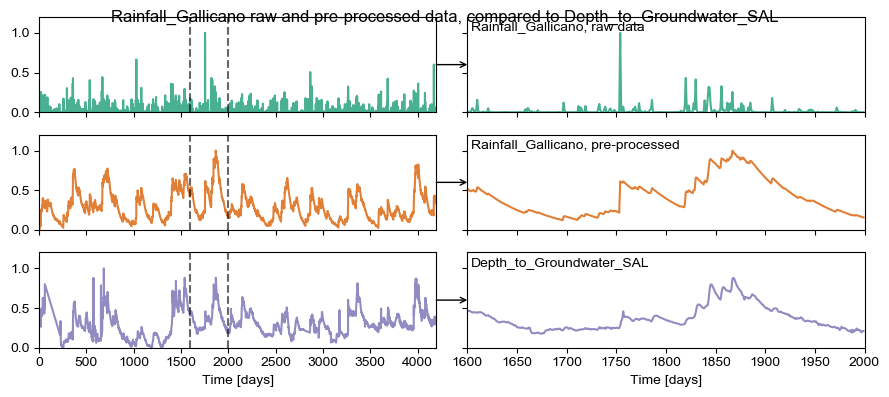

In [186]:
# Rainfall data analysis

r_i = 0
t_i = 1
rain_pp = exp_convolve(rain_ts[r_i], tau=54)
plot_preprocessing(rain_ts[r_i], rain_pp, rain_name[r_i], target_ts[t_i], target_name[t_i],
                   crop_min=1600, crop_max=2000, title=None)


Finding the optimal value of $\tau$ can reveal important information about the drainage mechanism for a particular subsystem, as well as help predict its groundwater level. 

To do this, we apply the convolution for a range of $\tau$ values and evaluate the correlation with the target as a function of $\tau$. The plots below show that the correlation peaks at around 50 days for SAL, whereas it peaks at ~ 800-1000 days for LT2. 

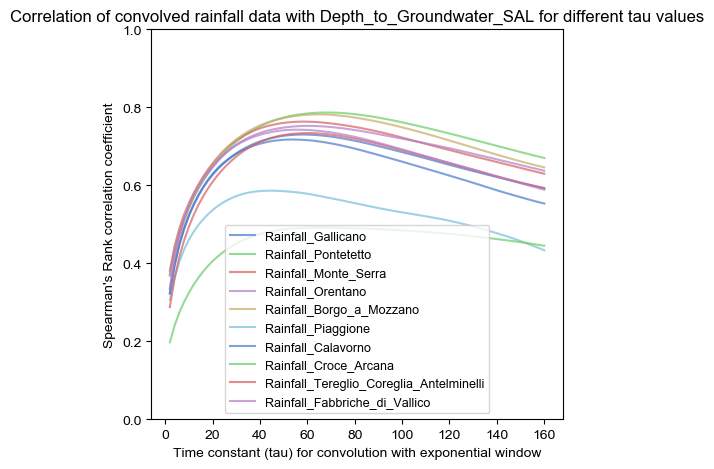

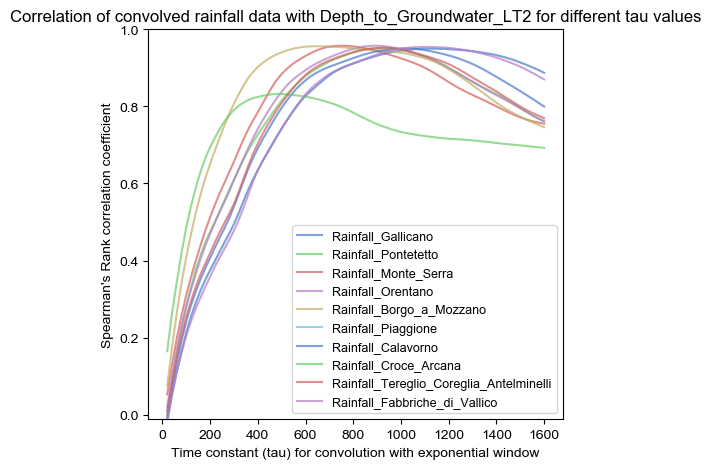

In [187]:
# Plot example of correlation for different tau values

tau_best, src_best = find_best_tau(target_ts=target_ts[1], rain_ts=rain_ts,
                         rain_name=rain_name, plot=True,
                         target_name=target_name[1],
                         tau_array=np.linspace(2, 160, 80))

tau_best, src_best = find_best_tau(target_ts=target_ts[0], rain_ts=rain_ts, plot=True,
                         target_name=target_name[0],
                         rain_name=rain_name,
                         tau_array=np.linspace(20, 1600, 80))


The large time scales associated with LT2 are likely due to the fact that this particular source is located significantly deeper than the rest (see plot below).

This fits with our understanding that shallower subsystems should experience more short term reactions to rainfall, as it likely reaches the subsystem more quickly and also drain out faster. Conversely for deeper subsystems, we expect the levels to react more slowly, with smaller short term effects.

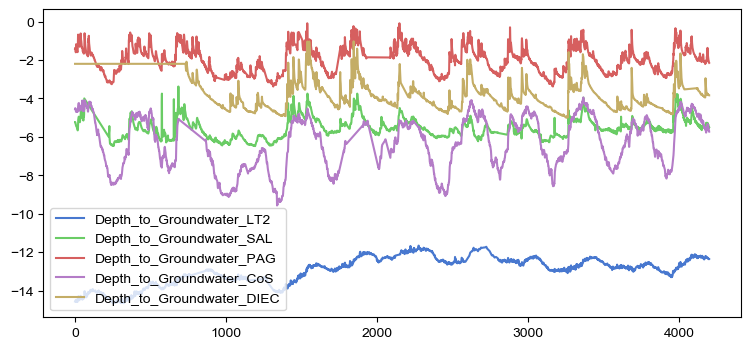

In [188]:
plt.figure(figsize=(9, 4))
for n in range(len(target_ts)):
    plt.plot(target_ts[n], label=target_name[n])
#plt.xlim(4100, 4300)
plt.legend()
plt.show()

The table below summarizes the optimal values of $\tau$ found for each rainfall/target combination. These time scales range between 46 - 120 days for the shallow subsystems, about 640 - 1200 days for the deep one (LT2). 

The color shading shows the correlation coefficient in each case, ranging roughly between 0.3 to 0.9. 

Note that 'Rainfall_Piaggione' produces unphsyical results, which are likely due to missing values. It was hence not considered in subsequent analysis.

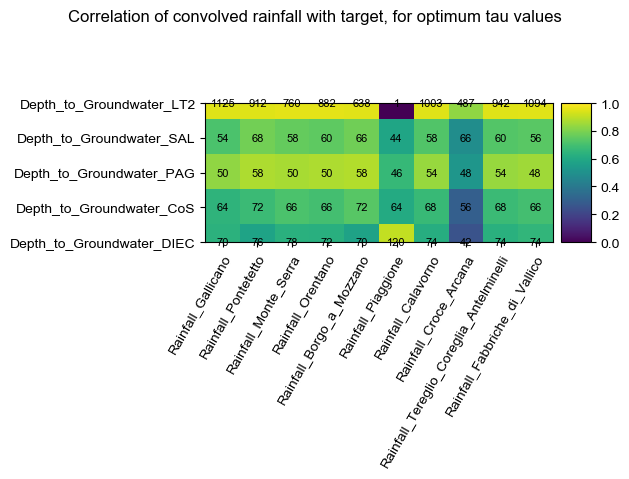

In [189]:
# Calculating optimum tau for each rainfall/target combination that
# maximises the Spearman's Rank correlation coefficient

rain_tau = find_all_best_tau(rain_ts, rain_name, target_ts, target_name,
                             target_0_tau_array=np.linspace(1, 2401, 80))


In [190]:
# Remove 'Rainfall_Piaggione' from pre-processed data list due to missing values
rain_filt = rain_ts.copy()
rain_name_pp = rain_name.copy()
del rain_filt[5]
del rain_name_pp[5]

# Create 3 different sets of pre-processed data
#   - rain_pp_shallow is a list of size (num selected rain), where each element is a time series array. This
#     array is just for the cross-correlation anaysis, so tau value is an average value of the best tau values for
#     the shallow groundwater variables (all but LT2).
#   - rain_pp_deep is a list of size (num selected rain), where each element is a time series array. This
#     array is just for the cross-correlation anaysis, so tau value is the best tau values for the deep
#     groundwater variable (LT2).
#   - rain_pp_all is a list of size (num target variables, num selected hydro), where each element is a time
#     series array. Each array has the preprocessed data with the optimum tau value for that particular
#     combination of hydro/target. This will be used for the model.

# Rainfall data preprocessing
rain_pp_shallow = []
rain_pp_deep = []
rain_pp_all = []
for n in range(len(rain_filt)):
    tau_shallow = np.mean(rain_tau[1:, n])
    tau_deep = np.mean(rain_tau[0, n])
    rain_pp_shallow.append(exp_convolve(rain_filt[n], tau_shallow))
    rain_pp_deep.append(exp_convolve(rain_filt[n], tau_deep))
    rain_pp_ = []
    for m in range(len(target_ts)):
        tau_ = rain_tau[m, n]
        rain_pp_.append(exp_convolve(rain_filt[n], tau_))
    rain_pp_all.append(rain_pp_)

# Flip the dimensions of the list
rain_pp_all = [list(x) for x in zip(*rain_pp_all)]


### 2.1.3 Volume data analysis 
Initial inspection of the 'volume' data showed the following:
- There is a relatively strong weekly pattern, and typically step changes every month. These are presumably linked to human activity/demand, and similar patterns are not clearly visible in the 'depth to groundwater' target variables. This suggests that it may be helpful to apply some smoothing to the volume data prior to modelling, in order to reduce the effect of the weekly/monthly variation.
- There are some very long timescale trends in the ampltidue, for example both Volume_CC1 and Volume_CC2 both increase gradually over the whole time period of the data. This timescale of change (perhaps linked to human activity/demand changes) is not present in the depth to groundwater variables, so there may be some benefit in removing it from the volume data prior to modelling.

In order to try to make the volume data more useful for modelling depth to groundwater, the following pre-processing was proposed based on the findings above:
- Caclulate the deviation of the volume data from a smoothed version of the data. The smoothed version of the data should be created with a relatively long smoothing window so that it represents the long term trend of the volume data.
- Apply some smoothing to the deviation calculated above, with a relatively short smoothing window, in order to reduce the effect of the weekly/monthly variation.

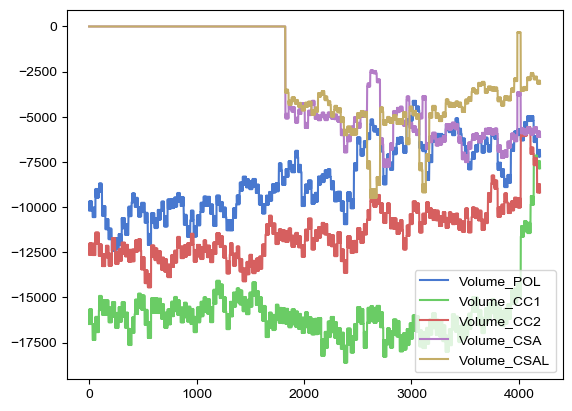

In [191]:
# Plot all volume data - for reference, not for final notebook

plt.figure()
for n in range(len(vol_ts)):
    plt.plot(vol_ts[n], label=vol_name[n])
plt.legend()
plt.show()
    

In [192]:
# Volume pre-processing

# find_best_vol_params(vol_ts[0], np.sum(target_ts, 0), smoothing_1=None, smoothing_2=None, plot=True)
# find_best_vol_params(vol_ts[0], np.sum(target_ts, 0), smoothing_1=None, smoothing_2=None, plot=True)
# find_best_vol_params(vol_ts[1], np.sum(target_ts, 0), smoothing_1=None, smoothing_2=None, plot=True)
# find_best_vol_params(vol_ts[2], np.sum(target_ts, 0), smoothing_1=None, smoothing_2=None, plot=True)

vol_pp = []
for n in range(len(vol_ts)):
    vol_pp.append(preprocess_vol(vol_ts[n]))


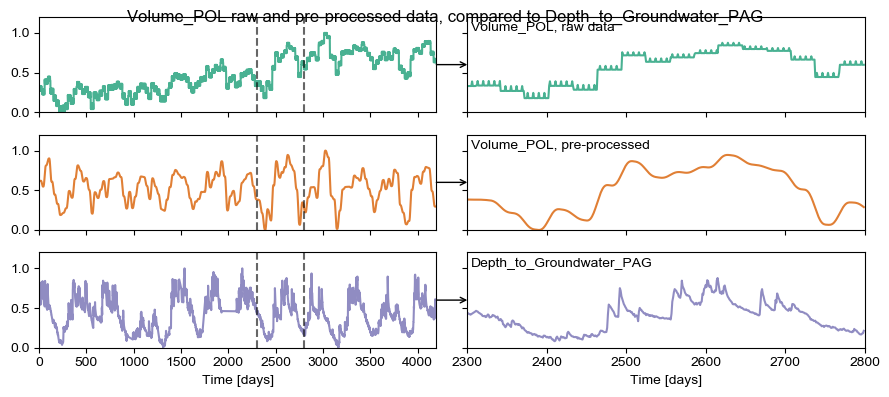

In [193]:
# Plot comparing original and pre-processed volume data

v_i = 0
t_i = 2
plot_preprocessing(vol_ts[v_i], vol_pp[v_i], vol_name[v_i], target_ts[t_i], target_name[t_i],
                   crop_min=2300, crop_max=2800, title=None)


### 2.1.4. Temperature data analysis
All of the temperature variables appear to be reasonably well correlated to each other, showing similar seasonal variation.
However, 'Temperature_Lucca_Orto_Botanico' has long periods of missing data, including the most recent ~1000 days, so it will not be used for the machine learning model.

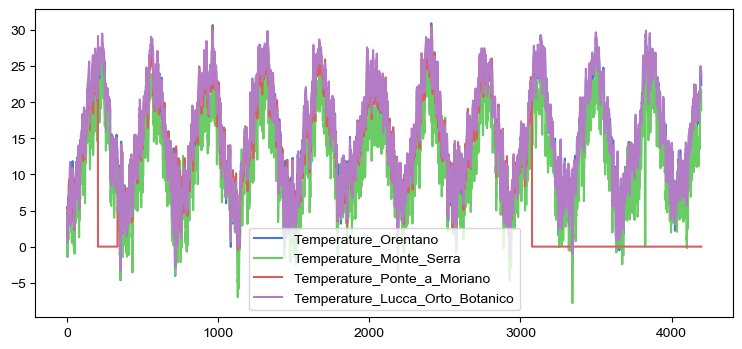

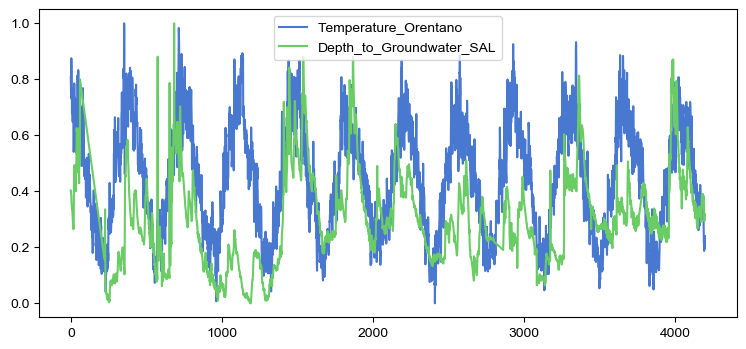

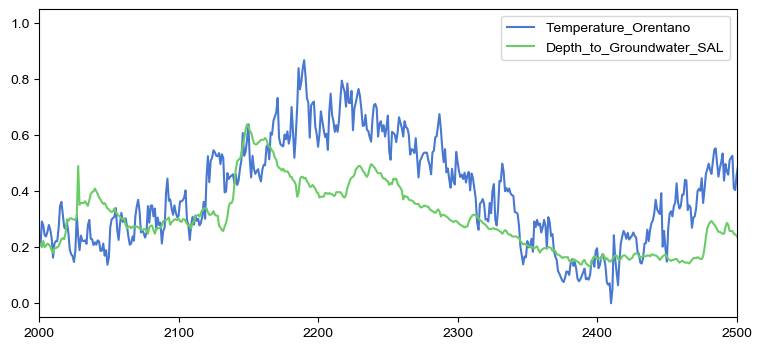

In [194]:
# Plot all temp data - for reference, not for final notebook

plt.figure(figsize=(9, 4))
for n in range(len(temp_ts)):
    plt.plot(temp_ts[n], label=temp_name[n])
plt.legend()
plt.show()

plt.figure(figsize=(9, 4))
plt.plot(normalise_0_to_1(-temp_ts[0]), label=temp_name[0])
plt.plot(normalise_0_to_1(target_ts[1]), label=target_name[1])
# plt.xlim(2000, 2500)
plt.legend()
plt.show()
plt.figure(figsize=(9, 4))
plt.plot(normalise_0_to_1(-temp_ts[0]), label=temp_name[0])
plt.plot(normalise_0_to_1(target_ts[1]), label=target_name[1])
plt.xlim(2000, 2500)
plt.legend()
plt.show()


In [195]:
# Remove 'Temperature_Lucca_Orto_Botanico' from pre-processed data list
temp_pp = temp_ts.copy()
temp_name_pp = temp_name.copy()
del temp_pp[2]
del temp_name_pp[2]


### 2.1.5 Hydrometry data analysis
The hydrometry data appears to be reasonably similar to the target variables, with a similar overall trend and with peaks in similar locations. Peaks in the hydrometry data tend to have a relatively steep 'ramp up', which matches the target variables well, however the 'ramp down' is  and a slightly less steep ramp down.

The same $\tau$ convolution operation was applied to the hydrometry data as for the rainfall (see Section 2.1.2). 

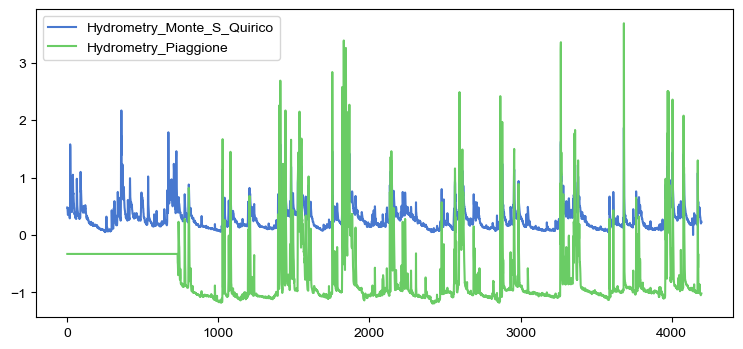

In [196]:
# Plot all hydrometry data - for reference, not for final notebook

plt.figure(figsize=(9, 4))
for n in range(len(hydro_ts)):
    plt.plot(hydro_ts[n], label=hydro_name[n])
plt.legend()
plt.show()


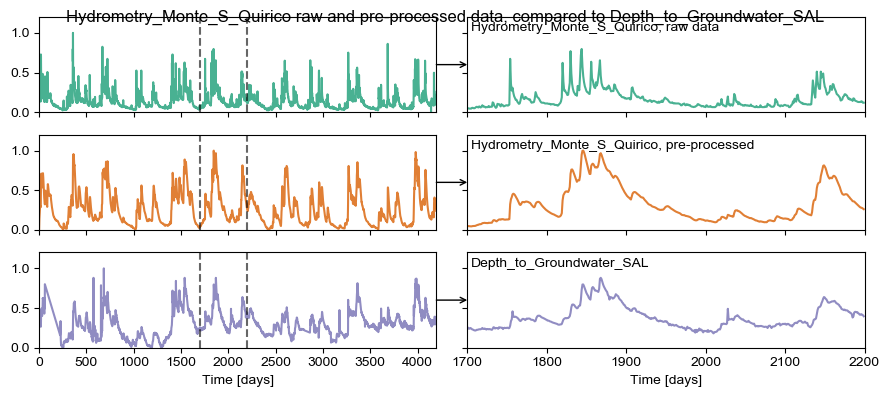

In [197]:
# Plot showing comparison of raw hydrometry data with pre-processed (smoothed) data

h_i = 0
t_i = 1
hydro_pp = exp_convolve(hydro_ts[h_i], tau=7, winlength=None)
plot_preprocessing(hydro_ts[h_i], hydro_pp, hydro_name[h_i], target_ts[t_i], target_name[t_i],
                   crop_min=1700, crop_max=2200, title=None)


The plot below summarizes the optimal $\tau$ values for each hydrometry/target combination. These values range between 8 - 28 days for the shallow subsystems, and around 800 days for the deep one (LT2).

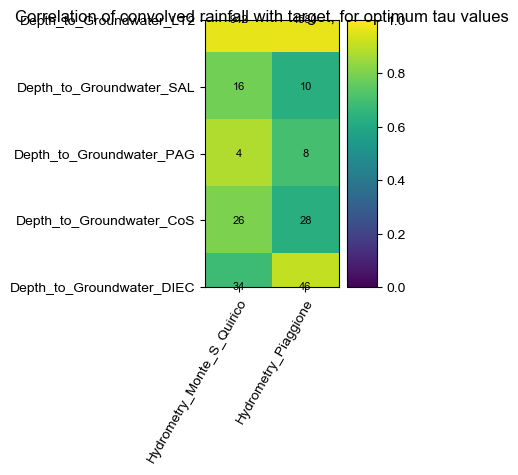

In [198]:
# Calculating optimum tau for each hydrometry/target combination that
# maximises the Spearman's Rank correlation coefficient

hydro_tau = find_all_best_tau(hydro_ts, hydro_name, target_ts, target_name,
                             target_0_tau_array=np.linspace(1, 2401, 80))


In [199]:
# Hydrometry data preprocessing

# Remove Piaggione from data list due to missing values
hydro_filt = hydro_ts.copy()
hydro_name_pp = hydro_name.copy()
if len(hydro_filt) == len(hydro_ts):
    del hydro_filt[1]
    del hydro_name_pp[1]

# Create 3 different sets of pre-processed data
#   - hydro_pp_shallow is a list of size (num selected hydro = 1), where each element is a time series array. This
#     array is just for the cross-correlation anaysis, so tau value is an average value of the best tau values for
#     the shallow groundwater variables (all but LT2).
#   - hydro_pp_deep is a list of size (num selected hydro = 1), where each element is a time series array. This
#     array is just for the cross-correlation anaysis, so tau value is the best tau values for the deep
#     groundwater variable (LT2).
#   - hydro_pp_all is a list of size (num target variables, num selected hydro), where each element is a time
#     series array. Each array has the preprocessed data with the optimum tau value for that particular
#     combination of hydro/target. This will be used for the model.

hydro_pp_shallow = []
hydro_pp_deep = []
hydro_pp_all = []
for n in range(len(hydro_filt)):
    tau_shallow = np.mean(hydro_tau[1:, n])
    tau_deep = np.mean(hydro_tau[0, n])
    hydro_pp_shallow.append(exp_convolve(hydro_filt[n], tau_shallow))
    hydro_pp_deep.append(exp_convolve(hydro_filt[n], tau_deep))
    hydro_pp_ = []
    for m in range(len(target_ts)):
        tau_ = hydro_tau[m, n]
        hydro_pp_.append(exp_convolve(hydro_filt[n], tau_))
    hydro_pp_all.append(hydro_pp_)

# Flip the dimensions of the list
hydro_pp_all = [list(x) for x in zip(*hydro_pp_all)]


### 2.1.6 Lag analysis

We were also interested in the correlation between groundwater level and rainfall, with different amounts of lag in the rainfall data. The line plot below shows results for the (deep) LT2 target, and reveals that the peak correlation arises with a lag of 50-100 days. This again shows how long it takes for rainfall to penetrate deep in the subsystem and affect the water level.

As illustrrated in the color plot, there is an optimal combination of $\tau$ and lag value that gives the best correlation for LT2. However, we find that adding lag did not have much effect for the shallower subsystems. So for simplicity and consistency, we pre-process all the rainfall data with $\tau$ convolution only and no lag. 

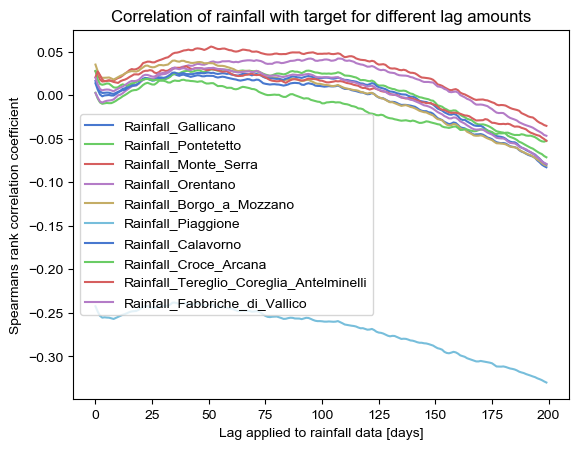

/Users/guptam/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


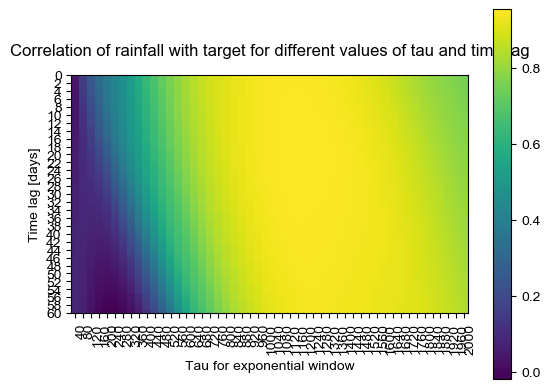

In [200]:
# Analysis of how lag applied to rainfall affects correlation with target

lag_array = np.arange(200)
plt.figure()
for n in range(len(rain_ts)):
    crosscorr_lag, lag_array = cross_corr_lag(
                                    normalise_0_to_1(target_ts[0]),
                                    normalise_0_to_1(rain_ts[n]),
                                    lag_array=lag_array)
    plt.plot(lag_array, crosscorr_lag, label=rain_name[n])
plt.legend()
plt.xlabel('Lag applied to rainfall data [days]')
plt.ylabel('Spearman''s rank correlation coefficient')
plt.title('Correlation of rainfall with target for different lag amounts')
plt.show()

    

target_test_ind = 0
rain_test_ind = 0
# lag_array = np.arange(30)
# tau_array = np.linspace(12, 90, 40).astype(np.int)
lag_array = np.linspace(0, 60, 31).astype(np.int)
tau_array = np.linspace(40, 2000, 50).astype(np.int)
data1 = target_ts[target_test_ind]
data2 = rain_ts[rain_test_ind]
sp_rank_cc, lag_array, tau_array = tau_and_lag_correl(data1,
                                                      data2,
                                                      lag_array=lag_array,
                                                      tau_array=tau_array,
                                                      plot=True)


## 2.2 Correlation analysis

The plots below are correlation matrices between the pre-processed input features and the raw target data, calculated day-by-day. The top panel is designed for deep groundwater level (LT2), such that the pre-processing of the rainfall and hydrometry uses large $\tau$ values (> 100 days). On the other hand, the bottom plot uses smaller $\tau$ values (~ 50 days). 

Note that rainfall and hydrometry are pre-processed, whereas the other variables are essentially used raw.

The matrices reveal the following information: 
- Most of the rainfall datasets are positively correlated 
- Most of the temperature datasets are positively correlated 
- Hydrometry and rainfall are positively correlated
- The temperature and rainfall datasets are negatively correlated (when using low $\tau$ values)
- Depth to Groundwater is well correlated with rainfall
- Depth to Groundwater is well correlated with temperature (for all targets except LT2)
- Most of the volume data is not well correlated, neither to each other nor to targets. This is except Volume_POL, which has correlation with LT2


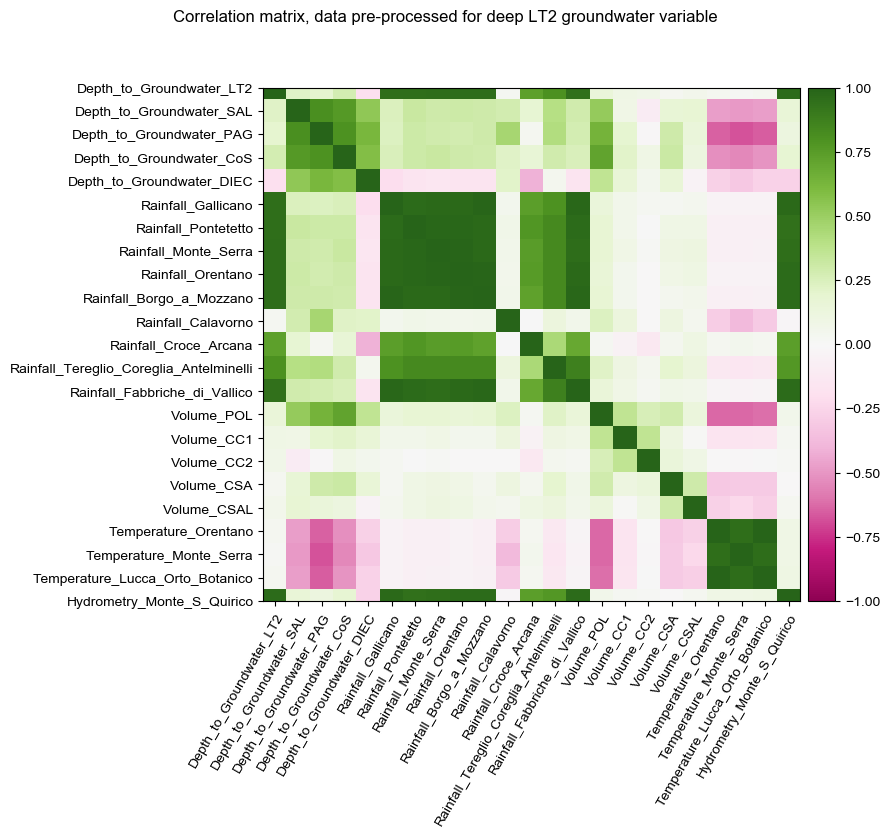

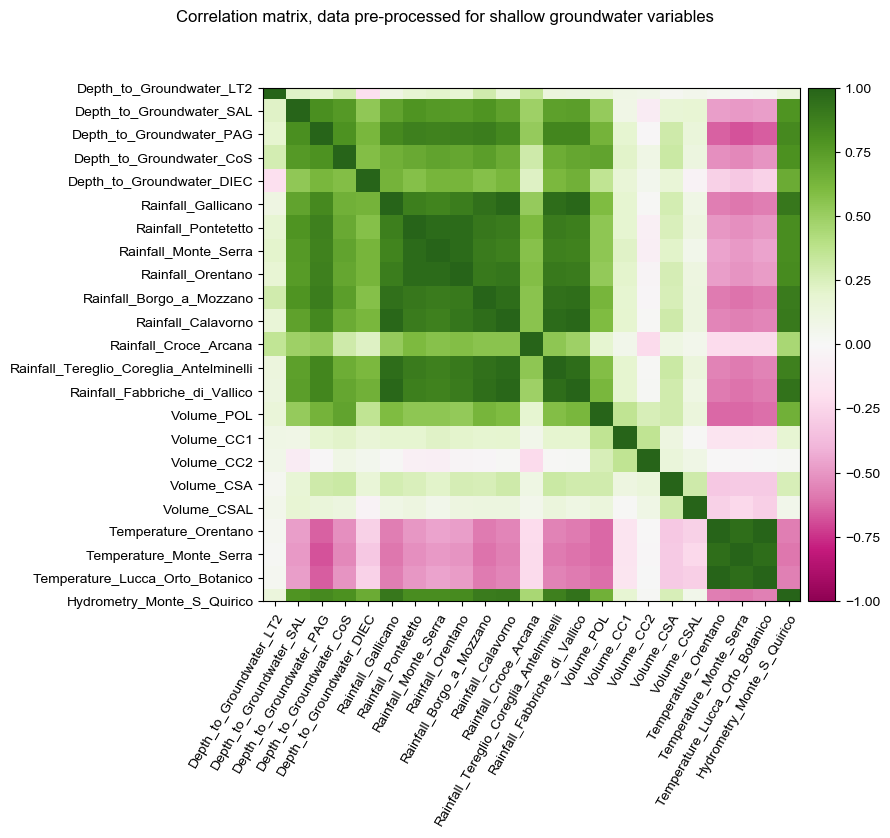

In [201]:
# Since many of the variables seem to show a high correlation with each other, using all of them to train the model is likely to add unnecessary computation time, without improvement over a model trained with a smaller selection of variables. Therefore, some down-selection of variables was carried out prior to modelling, in order to make the machine learning model as computationally efficient as possible. This was done by calculating the cross-correlation of the pre-processed data, and evaluating the expected usefulness of each variable based on the following principles:
# 1. If input variables have a strong correlation to the target variable, they are likely to be useful in training the model.
# 2. If input variables have a strong correlation with other input variables, there may be limited benefit in including all of them in the model.
# During the pre-processing of the rainfall and hydrometry data, it was found that for 'Depth_to_Groundwater_LT2', the optimum time constant (tau) for the convolution was much higher than the optimum value for the other groundwater variables. This was thought to be because the LT2 sub-system is significantly deeper underground than the other variables, and therefore it takes longer for the other variables to impact the level. In order to best evaluate the correlation of the variables, two different correlation matrices were calculated: one with variable pre-processing optimised for the shallower groundwater variables; and one with variable pre-processing optimised for the deepest groundwater variable LT2.

# Plot correlation matrices

# Combine all pre-processed data for the shallow groundwater variables
data_pp_shallow = np.concatenate((np.asarray(target_ts),
                                  np.asarray(rain_pp_shallow),
                                  np.asarray(vol_pp),
                                  np.asarray(temp_pp),
                                  np.asarray(hydro_pp_shallow)))
name_pp_shallow = target_name + rain_name_pp + vol_name + temp_name_pp + hydro_name_pp

# Combine all pre-processed data for the deep groundwater variables
data_pp_deep = np.concatenate((np.asarray(target_ts),
                               np.asarray(rain_pp_deep),
                               np.asarray(vol_pp),
                               np.asarray(temp_pp),
                               np.asarray(hydro_pp_deep)))
name_pp_deep = target_name + rain_name_pp + vol_name + temp_name_pp + hydro_name_pp

# Plot correlation matrices
plot_correl_matrix(data_pp_deep, name_pp_deep,
                   title='Correlation matrix, data pre-processed for deep LT2 groundwater variable')
plot_correl_matrix(data_pp_shallow, name_pp_shallow,
                   title='Correlation matrix, data pre-processed for shallow groundwater variables')


## 2.3 Machine Learning Prediction 

We use a machine learning model to predict the depth to ground water given past timeseries information. We explore the following scenarios:
1. LSTM vs. Multi-Layer-Perceptron (MLP) - TODO
2. Including versus excluding the target timeseries as an input to the predictive model
3. Importance of the various features in the predictive skill
4. Daily versus weekly predictions
5. Predicting several timesteps (days or weeks) in advance 

### 2.3.1 Including versus excluding the target timeseries as a model input

The line plots below show the timeseries prediction of the model, with and without the inclusion of past target data as an input, respectively. Note that other targets are excluded from the inputs in all cases. As expected, the model performs better when the target data is included, but it still has reasonable predictive skill without it. 

The color plots show the degree of activation of the weights associated with each input variable in the MLP model, as a function of the steps back considered. In this example, we feed the model t-30 days of past data to predict the target at time t. Those plots reveal the following:
- When included, the target has biggest weighting. This is consistent with it being useful in the prediction.
- Rainfall and hydrometry have biggest weights when the target is excliuded
- The most recent days have significantly larger weights than past ones, suggesting that perhaps we may not need to look back so far into the past to have a reasonable prediction. This idea should be tested more throughly though.

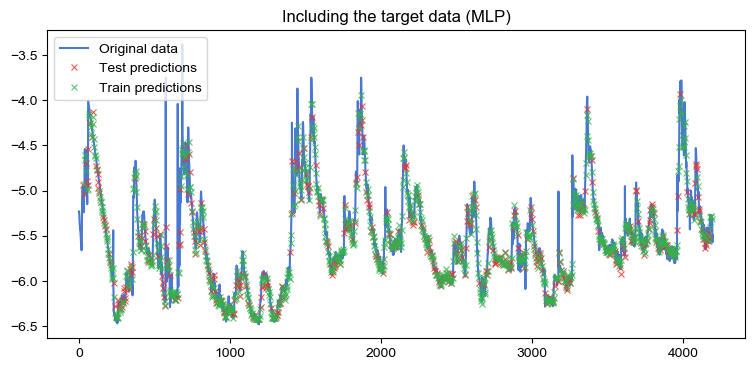

Train Score: 0.08 RMSE
Test Score: 0.15 RMSE


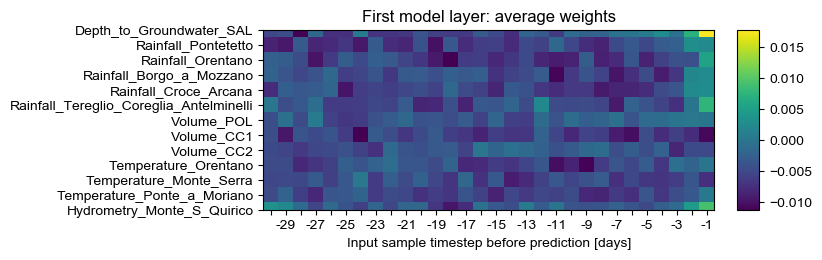

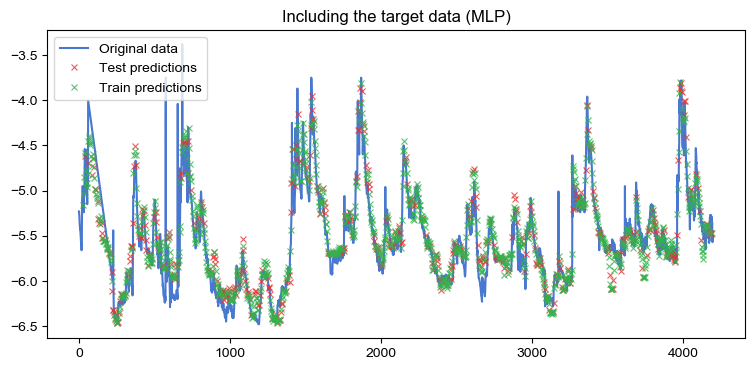

Train Score: 0.16 RMSE
Test Score: 0.17 RMSE


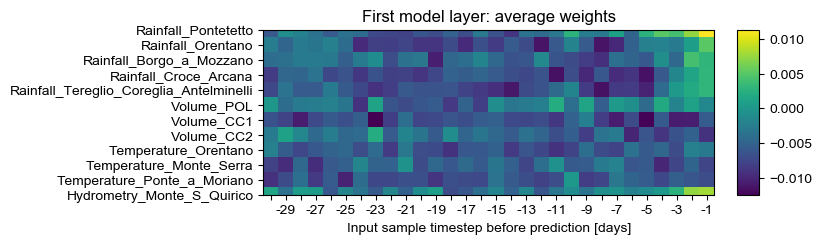

In [202]:
# LSTM with or without target data


# Including the target data 

# Choose variables to include in model by their indices
target_ind = 1
model_rain_ind = [1, 3, 4, 7, 8]
model_vol_ind = [0, 1, 2]
model_temp_ind = [0, 1, 2]
model_hydro_ind = [0]

# Getting the names of the selected features
a1 = [rain_name[i] for i in model_rain_ind]
a2 = [vol_name[i] for i in model_vol_ind]
a3 = [temp_name[i] for i in model_temp_ind]
a4 = [hydro_name[i] for i in model_hydro_ind]
input_names = [target_name[target_ind]] + a1 + a2 + a3 + a4

# Compile target data and inputs to arrays
target_data = target_ts[target_ind]
model_input_data = compile_model_input_variables(model_rain_ind,
                                                 model_vol_ind,
                                                 model_temp_ind,
                                                 model_hydro_ind,
                                                 rain_pp_all[target_ind],
                                                 vol_pp,
                                                 temp_pp,
                                                 hydro_pp_all[target_ind],
                                                 target_ts[target_ind].size)

# Create ML model class and run it
Model_using_target = ML_model(target_data=target_data,
                                input_data=model_input_data,
                                use_target=True,
                                look_back=30,
                                chunk_step=3,
                                train_ratio=0.67,
                                num_epochs=50,
                                batch_size=5,
                                predict_steps=5,
                                plot=False,
                                verbose=0)
Model_using_target.run(model_type='MLP')

# Excluding the target data
Model_excluding_target = ML_model(target_data=target_data,
                                input_data=model_input_data,
                                use_target=False,
                                look_back=30,
                                chunk_step=3,
                                train_ratio=0.67,
                                num_epochs=70,
                                batch_size=5,
                                predict_steps=5,
                                plot=False,
                                verbose=0)
Model_excluding_target.run(model_type='MLP')


Model_using_target.plot_predict_one_step(title="Including the target data (MLP)")
print('Train Score: %.2f RMSE' % (Model_using_target.trainRMSE[0]))
print('Test Score: %.2f RMSE' % (Model_using_target.testRMSE[0]))
Model_using_target.plot_weights(input_names)

Model_excluding_target.plot_predict_one_step(title="Including the target data (MLP)")
print('Train Score: %.2f RMSE' % (Model_excluding_target.trainRMSE[0]))
print('Test Score: %.2f RMSE' % (Model_excluding_target.testRMSE[0]))
Model_excluding_target.plot_weights(input_names[1:])





### 2.3.2 Assessing variable importance
In order to quantify how important different variables are in terms of model accuracy, the following method was used:
1. A multi-layer perceptron model was trained using only one input variable to predict the target one day ahead.
2. The RMSE of the predictions made using this model were calculated.
3. The above steps were repeated for each of the variables in the dataset in turn and the RMSE scores were compared to assess which variables were most effective at modelling the target.

The bar plots below highlight the importance of the target, rainfall and hydrometry in the MLP's predictive skill. While the exact order depends on each target individually, these results are generally consistent with the correlation matrices shown in Section 2.2. In the case of LT2, it is additionally interesting to note that several rainfall and hydrometry datasets are more useful than the target itself in the prediction (although by a small margin). 

These results (and other experiments not shown here for brevity) suggest that using a smaller number of features could still provide a similar level of predictive skill for lower computing cost.

In [203]:
# Choose variables to include in model by their indices
target_ind = 0
model_rain_ind = [0, 1, 2, 3, 4, 5, 6, 7, 8]
model_vol_ind = [0, 1, 2]
model_temp_ind = [0, 1, 2]
model_hydro_ind = [0]

# Getting the names of the selected features
a1 = [rain_name[i] for i in model_rain_ind]
a2 = [vol_name[i] for i in model_vol_ind]
a3 = [temp_name[i] for i in model_temp_ind]
a4 = [hydro_name[i] for i in model_hydro_ind]
input_names = [target_name[target_ind]] + a1 + a2 + a3 + a4

# Compile target data and inputs to arrays
target_data = target_ts[target_ind]
model_input_data_ref = compile_model_input_variables(model_rain_ind,
                                                 model_vol_ind,
                                                 model_temp_ind,
                                                 model_hydro_ind,
                                                 rain_pp_all[target_ind],
                                                 vol_pp,
                                                 temp_pp,
                                                 hydro_pp_all[target_ind],
                                                 target_ts[target_ind].size)


# Running LSTM a total of tot_idx times, each time removing one of the input features
tot_idx = 1 + model_input_data_ref.shape[0]
all_scores = np.empty(tot_idx)
model_input_data = model_input_data_ref

for i in range(tot_idx):
    model_input_data = np.expand_dims(model_input_data_ref[i-1, :], axis=0)
            
    # Making the model instance
    model_tmp = ML_model(target_data=target_data,
                                    input_data=model_input_data,
                                    use_target=False,
                                    look_back=30,
                                    chunk_step=20,
                                    train_ratio=0.67,
                                    num_epochs=30,
                                    batch_size=5,
                                    predict_steps=1,
                                    plot=False,
                                    verbose=0)
    model_tmp.run(model_type='MLP')
    
    all_scores[i] = (model_tmp.trainRMSE + model_tmp.testRMSE)/2



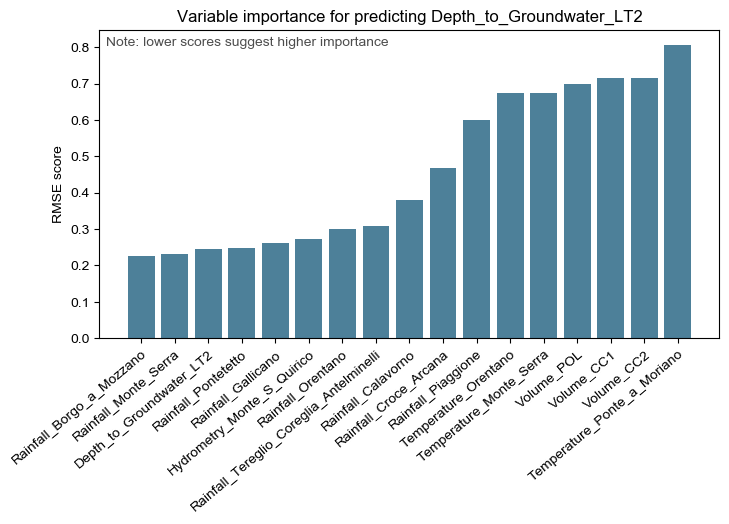

In [204]:
# Getting ranking 
ranking = np.argsort(1*all_scores) # Sorting in ascending order
sorted_scores = all_scores[ranking]
sorted_names = [input_names[i] for i in ranking]

# Plotting bar chart
plt.figure(figsize=(8, 4))
ax = plt.subplot(111)
x_pos = np.arange(0,len(sorted_names))
plt.bar(x_pos, sorted_scores, color=[0.3, 0.5, 0.6])
plt.ylabel("RMSE score")
plt.title("Variable importance for predicting {}".format(input_names[0]))
ax.text(0.01, 0.98, 'Note: lower scores suggest higher importance',
        transform=ax.transAxes, va='top', ha='left', color=[0.3, 0.3, 0.3])
plt.xticks(x_pos, sorted_names, rotation=40, ha="right",
                 rotation_mode="anchor")
plt.show()

In [205]:
# Choose variables to include in model by their indices
target_ind = 1
model_rain_ind = [0, 1, 2, 3, 4, 5, 6, 7, 8]
model_vol_ind = [0, 1, 2]
model_temp_ind = [0, 1, 2]
model_hydro_ind = [0]

# Getting the names of the selected features
a1 = [rain_name[i] for i in model_rain_ind]
a2 = [vol_name[i] for i in model_vol_ind]
a3 = [temp_name[i] for i in model_temp_ind]
a4 = [hydro_name[i] for i in model_hydro_ind]
input_names = [target_name[target_ind]] + a1 + a2 + a3 + a4

# Compile target data and inputs to arrays
target_data = target_ts[target_ind]
model_input_data_ref = compile_model_input_variables(model_rain_ind,
                                                 model_vol_ind,
                                                 model_temp_ind,
                                                 model_hydro_ind,
                                                 rain_pp_all[target_ind],
                                                 vol_pp,
                                                 temp_pp,
                                                 hydro_pp_all[target_ind],
                                                 target_ts[target_ind].size)


# Running LSTM a total of tot_idx times, each time removing one of the input features
tot_idx = 1 + model_input_data_ref.shape[0]
all_scores = np.empty(tot_idx)
model_input_data = model_input_data_ref

for i in range(tot_idx):
    model_input_data = np.expand_dims(model_input_data_ref[i-1, :], axis=0)
            
    # Making the model instance
    model_tmp = ML_model(target_data=target_data,
                                    input_data=model_input_data,
                                    use_target=False,
                                    look_back=30,
                                    chunk_step=20,
                                    train_ratio=0.67,
                                    num_epochs=30,
                                    batch_size=5,
                                    predict_steps=1,
                                    plot=False,
                                    verbose=0)
    model_tmp.run(model_type='MLP')
    
    all_scores[i] = (model_tmp.trainRMSE + model_tmp.testRMSE)/2



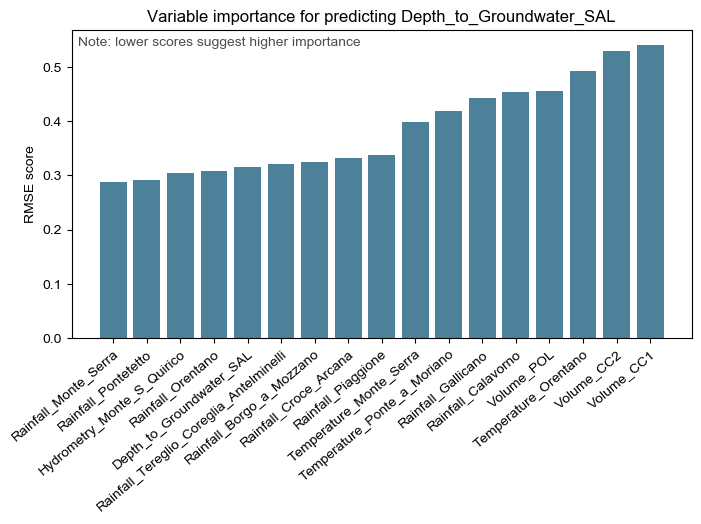

In [206]:
# Getting ranking 
ranking = np.argsort(1*all_scores) # Sorting in ascending order
sorted_scores = all_scores[ranking]
sorted_names = [input_names[i] for i in ranking]

# Plotting bar chart
plt.figure(figsize=(8, 4))
ax = plt.subplot(111)
x_pos = np.arange(0,len(sorted_names))
plt.bar(x_pos, sorted_scores, color=[0.3, 0.5, 0.6])
plt.ylabel("RMSE score")
plt.title("Variable importance for predicting {}".format(input_names[0]))
ax.text(0.01, 0.98, 'Note: lower scores suggest higher importance',
        transform=ax.transAxes, va='top', ha='left', color=[0.3, 0.3, 0.3])
plt.xticks(x_pos, sorted_names, rotation=40, ha="right",
                 rotation_mode="anchor")
plt.show()

### 2.3.3 Predictability horizon

The results presented so far only considered predicting a single timestep at a time. However, it may be important to predict several steps ahead (time t+n), given information only until time t. The plot below shows the results from such multi-step predictions, along with the original target timeseries. The results suggest that the MLP can reasonably capture the overall trend for several days in advance, when the latter doesn't have very large jumps. It also does not do very well in predicting day-to-day fluctuations. 

TODO: Horizon with one line per target (at least one LT2 and one other)

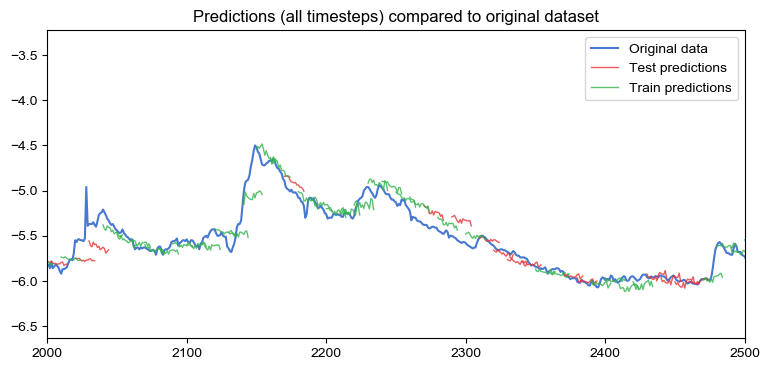

In [207]:

def get_predict_horizon(target_data, testPredict, testYind, predict_steps):
    testTarget = np.empty(np.shape(testPredict))
    for ii in range(len(testYind)):
        testTarget[ii, :] = target_data[testYind[ii]: testYind[ii] + predict_steps]
    predict_horizon = np.empty((predict_steps))
    for ii in range(predict_steps):
#         predict_horizon[ii], _ = stats.spearmanr(testTarget[:,ii], testPredict[:,ii])
        predict_horizon[ii] = math.sqrt(mean_squared_error(testTarget[:,ii], testPredict[:,ii]))
    return predict_horizon

# Choose variables to include in model by their indices
target_ind = 1
model_rain_ind = [0, 1, 2, 3, 4, 5, 6, 7, 8]
model_vol_ind = [0, 1, 2]
model_temp_ind = [0, 1, 2]
model_hydro_ind = [0]

# Getting the names of the selected features
a1 = [rain_name[i] for i in model_rain_ind]
a2 = [vol_name[i] for i in model_vol_ind]
a3 = [temp_name[i] for i in model_temp_ind]
a4 = [hydro_name[i] for i in model_hydro_ind]
input_names = a1 + a2 + a3 + a4

# Compile target data and inputs to arrays
target_data = target_ts[target_ind]
model_input_data = compile_model_input_variables(model_rain_ind,
                                                 model_vol_ind,
                                                 model_temp_ind,
                                                 model_hydro_ind,
                                                 rain_pp_all[target_ind],
                                                 vol_pp,
                                                 temp_pp,
                                                 hydro_pp_all[target_ind],
                                                 target_ts[target_ind].size)
# # Model parameters
# look_back = 80
# chunk_step = 10
# train_ratio = 0.67
# num_epochs = 200
# batch_size = 5


predict_steps = 15

# Run ML model
model_day_horizon = ML_model(target_data=target_data,
                                input_data=model_input_data,
                                use_target=True,
                                look_back=60,
                                chunk_step=10,
                                train_ratio=0.67,
                                num_epochs=100,
                                batch_size=5,
                                predict_steps=predict_steps,
                                plot=False,
                                verbose=0)
model_day_horizon.run(model_type='MLP')
model_day_horizon.plot_predict_all_steps(crop_min=2000, crop_max=2500)


The plot below show the RMSE as a function of the number of days in advance it predicts. As expected, the error increases with the number of steps. We hope that this can give ACEA an idea of the predictivility horizon of this model.

In [ ]:
# Calculate and plot RMSE against prediction look ahead
# predict_horizon = get_predict_horizon(target_data, testPredict_advance, testYind_advance, predict_steps)
predict_horizon = model_day_horizon.testRMSE
plt.figure()
plt.plot(np.arange(0, predict_steps), predict_horizon)
plt.title("Predictability horizon")
plt.xlabel("Steps in advance [days]")
plt.ylabel("RMSE")
plt.show()

### 2.3.4 Weekly analysis 

Finally, we perform the same analysis here as above (Section 2.3.3), but this time using weekly averaged data, rather than daily. It might indeed be useful to predict the ground waterr level over the coming weeks, without caring about day-to-day fluctuations.

The results below show that by performing this weekly average, these short term fluctuations are smoothed out to a certain extent, and it becomes easier for the model to make predictions. We also include a predicitability horizon plot with the weekly data, which provides information about how far in advance one can make predictions. 

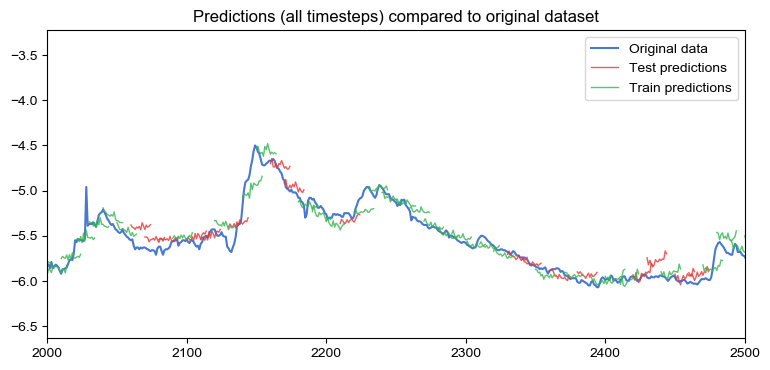

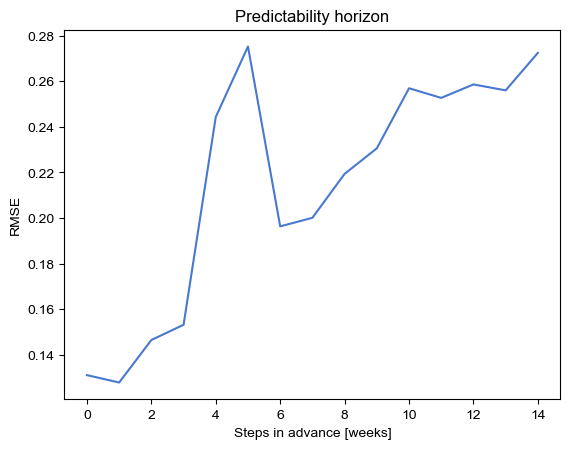

In [97]:

def get_data_mean(field, average_fac):
    """
    Calculate mean of data array along last axis. field is a vector,
    which can be more than 1D. The last dimension of field will be averaged,
    so could be shape: (num_timesteps)
    or shape: (num features, num_timesteps)
    The output will be an array with the same number of dimensions as
    field, but with the size of the last axis reduced depending on the
    averaging amount 'average_fac'.
    """
    num_dim = field.ndim
    num_timesteps = field.shape[-1]
    num_av = np.int(np.floor(num_timesteps / average_fac))
    
    # Get shape for temporary reshaped array
    if num_dim > 1:
        feature_shape = list(field.shape[:-1])
        tmp_shape = feature_shape + [num_av, average_fac]
    else:
        tmp_shape = [num_av, average_fac]
        
    # Remove earliest timesteps if num_timesteps is not divisible by average_fac
    field_crop = np.delete(field, np.s_[: -num_av*average_fac], axis=-1)
    
    # Take mean of data
    tmp = np.reshape(field_crop, tmp_shape)
    data_mean = np.mean(tmp, axis=-1)
    
    return data_mean

# Choose variables to include in model by their indices
target_ind = 1
model_rain_ind = [0, 1, 2, 3, 4, 5, 6, 7, 8]
model_vol_ind = [0, 1, 2]
model_temp_ind = [0, 1, 2]
model_hydro_ind = [0]

# Getting the names of the selected features
a1 = [rain_name[i] for i in model_rain_ind]
a2 = [vol_name[i] for i in model_vol_ind]
a3 = [temp_name[i] for i in model_temp_ind]
a4 = [hydro_name[i] for i in model_hydro_ind]
input_names = a1 + a2 + a3 + a4

# Compile target data and inputs to arrays
target_data = target_ts[target_ind]
model_input_data = compile_model_input_variables(model_rain_ind,
                                                 model_vol_ind,
                                                 model_temp_ind,
                                                 model_hydro_ind,
                                                 rain_pp_all[target_ind],
                                                 vol_pp,
                                                 temp_pp,
                                                 hydro_pp_all[target_ind],
                                                 target_ts[target_ind].size)

# Calculate 1 week average
average_fac = 7
target_data_weekly = get_data_mean(target_data, average_fac)
input_data_weekly = get_data_mean(model_input_data, average_fac)

# Run ML model
predict_steps = 15
model_weekly = ML_model(target_data=target_data,
                                input_data=model_input_data,
                                use_target=True,
                                look_back=60,
                                chunk_step=10,
                                train_ratio=0.67,
                                num_epochs=100,
                                batch_size=5,
                                predict_steps=predict_steps,
                                plot=False,
                                verbose=0)
model_weekly.run(model_type='MLP')
model_weekly.plot_predict_all_steps(crop_min=2000, crop_max=2500)

predict_horizon = model_weekly.testRMSE
plt.figure()
plt.plot(np.arange(0, predict_steps), predict_horizon)
plt.title("Predictability horizon")
plt.xlabel("Steps in advance [weeks]")
plt.ylabel("RMSE")
plt.show()


## 2.4 Summary of Aquifier Auser
- It was found that when the rainfall and hydrometry data was filtered with an exponential window, the correlation to the target variables increased significantly. In general, the deeper the aquifier subsystems, the greater the optimum time constants for the filter. This makes logical sense based on an understanding of the aquifiers, since it takes more time for the rainfall to reach deeper groundwater.

- With the past target data included as an input, the model appeared to work well in predictions, with the most recent target data having the biggest weightings in the model.

- When the target was excluded as an input, the prediction error increased, although the remaining features still provided a relatively good level of accuracy

- The rainfall and hydrometry variables (filtered with an exponential window) seem to be the most useful in predicting the target variables, aside from the target itself. It appears that the rainfall affects the groundwater quite directly (in particular, the shallower groundwater variables), and likely to be the main physical mechanism causing the spikes in the groundwater level. If this is the case, then the accuracy of the model may be limited by the unpredictability of the rainfall in the coming days. Whether or not it rains the next day is likely to have a significant effect on the groundwater levels that day (in the shallower sub-systems), which is fundamentally difficult to predict. It is possible that the inclusion of weather forecast data in the model, such as predicted rainfall, might improve accuracy.

- Temperature appears to be able to make reasonable predictions of target on it's own, although not as effective as rainfall or hydrometry variables. This may be because of a link between temperature and rain, particularly over longer timescales, due to local climate fluctuations that affect both variables.

- There may be some improvement in accuracy if all target variables are included in the model, but the focus of this study was to investigate the effect of external variables rather than to optimise the model performance.

- It may be possible to learn more about the effect of external variables by filtering the rainfall variables with different time constants and assessing the impact on model performance. By using time constants of the order of tens of days, daily fluctuations in rainfall are smoothed out, hence the model may have difficulty resolving all of the daily fluctuations in the target (if those are indeed linked to daily rainfall). It would be interesting to know where the short term fluctuations come from, and if they are indeed predictable.

- Predictability horizon and weekly vs daily??????????

TODO: number these and summarize the text. Maybe fewer points would be more impactful..?

# 3. Water Spring Amiata
## 3.1 Data pre-processing
### 3.1.1 Handling missing data
First, the data was read in and an analysis of missing data was carried out.

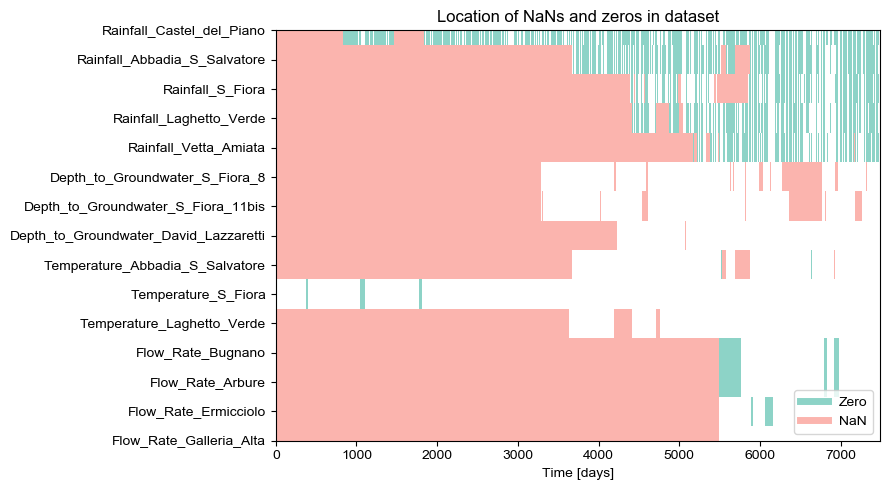

In [100]:
# Pre-processing data

# Importing all data into pandas dataframe
df = pd.read_csv(files[6])

# Find and plot gaps in the data
all_data, col_names, is_nan, is_zero = find_data_gaps(df, plot=True, title=None)


The plot above shows that there is a significant amount of data missing over the total time period, either in the form of NaNs, or zeros. In the case of the rainfall data, the zeros are considered to be 'real data' since there are many days with zero rainfall, however for the other data it is assumed that zeros imply missing data.

Since there are many NaNs in most of the features for the first ~5500 days, including all of the target variables, it was decided that this time period would not be used for the model at all.


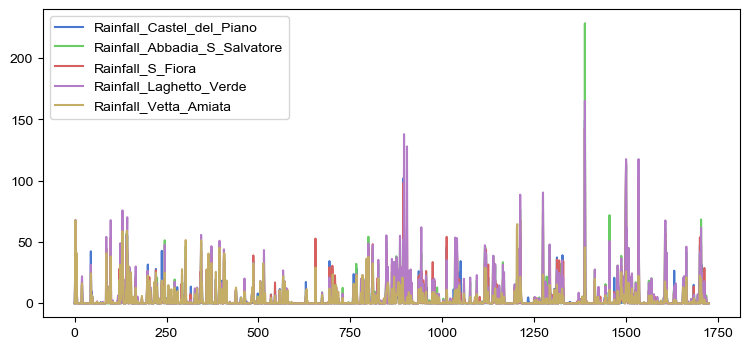

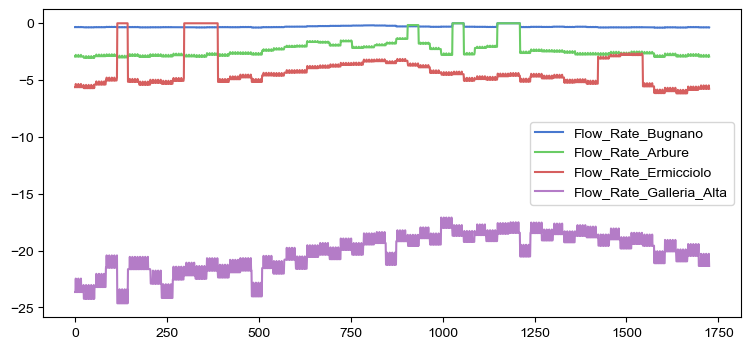

In [101]:
# Find column indices for different datatypes
datatypes, col_inds = find_datatypes(df)

# Get time series data for all variable types
start_ind = 5760
rain_ts, rain_name = get_time_series(col_inds[0], start_ind=start_ind, fill_zeros=False)
depth_ts, depth_name = get_time_series(col_inds[1], start_ind=start_ind)
temp_ts, temp_name = get_time_series(col_inds[2], start_ind=start_ind)
target_ts, target_name = get_time_series(col_inds[5], start_ind=start_ind) 

plt.figure(figsize=(9, 4))
for n in range(len(rain_ts)):
    plt.plot(rain_ts[n], label=rain_name[n])
plt.legend()
plt.show()

plt.figure(figsize=(9, 4))
for n in range(len(target_ts)):
    plt.plot(target_ts[n], label=target_name[n])
plt.legend()
plt.show()

### 3.1.2 Flow Rate analysis
There are some large step changes in some of the Flow Rate variables, where the rate becomes zero (or close to zero) for several days in a row. Without understanding more details about the data collection, it is difficult to know whether these deviations represent reality or whether they are missed/incorrect recordings. However, it is likely that including them in the modelling will make it significantly more challenging to make accurate predictions, since they appear to be anomalous and unrelated to other features in this dataset.
It was decided that these values should be filled by interpolation, to allow the model to better represent the majority of the data.

The potentially anomalous data was identified by the following method:
- Calculate the moving average of the time series with a large time window
- Calculate the standard deviation of the time series
- Set upper and lower thresholds at 'moving average +/- 1.6*std'
- Any values outside of these thresholds were deemed to be potentially anomalous

In [102]:
"""Flow rate target variables"""

def interp_nan(arr):
    ser = pd.Series(arr)
    ser.interpolate(method='linear', inplace=True)
    out = ser.to_numpy()
    return out

# Find potentially anomalous samples by deviation from moving average
flow_ts_filt = []
flow_name = []
flow_mov_av = []
flow_thresh_hi = []
flow_thresh_lo = []
moving_av_win = 450
for n in range(len(target_ts)):
    removed_zeros = np.where(target_ts[n]==0, np.nan, target_ts[n])
    overall_av = np.nanmean(removed_zeros)
    filled_zeros = np.where(np.isnan(removed_zeros), overall_av, removed_zeros)
    mov_av = movingav(filled_zeros, moving_av_win, winfunc=None)
    thresh_hi = mov_av + 1.6*np.nanstd(removed_zeros)
    thresh_lo = mov_av - 1.6*np.nanstd(removed_zeros)
    flow_thresh_hi.append(thresh_hi)
    flow_thresh_lo.append(thresh_lo)
    is_outlier = np.logical_and(target_ts[n] < thresh_hi, target_ts[n] > thresh_lo)
    ts_filt = np.where(is_outlier, target_ts[n], np.nan)
    flow_mov_av.append(mov_av)
    flow_ts_filt.append(ts_filt)

# Prob don't show this plot, at least not how it is atm - bit of a mess!
# smoothing_win = 1
# plt.figure()
# for n in range(len(target_ts)):
#     smoothed = moving_average(target_ts[n], smoothing_win)
#     plt.plot(flow_mov_av[n], lw=1, color=[0, 0, 0, 0.5])
#     plt.plot(flow_thresh_hi[n], lw=1, color=[0, 0, 0, 0.5])
#     plt.plot(flow_thresh_lo[n], lw=1, color=[0, 0, 0, 0.5])
#     plt.plot(smoothed, lw=1, color=[0, 0, 0, 0.7])
#     plt.plot(flow_ts_filt[n], label=target_name[n], alpha=0.9)
# plt.legend()
# plt.title('Flow rates')
# plt.show()

target_ts_raw = np.copy(target_ts)
for n in range(len(target_ts)):
    target_ts[n] = interp_nan(flow_ts_filt[n])



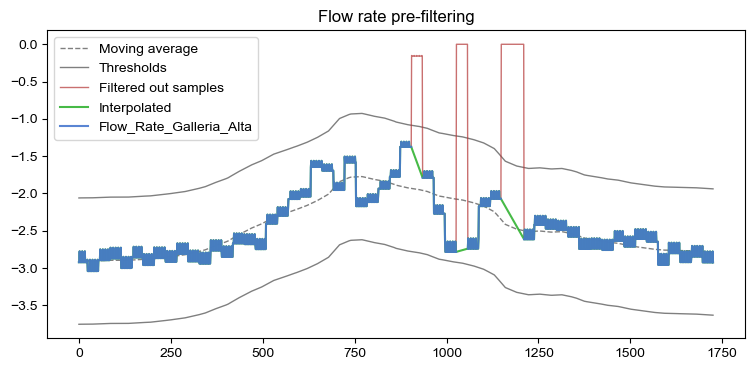

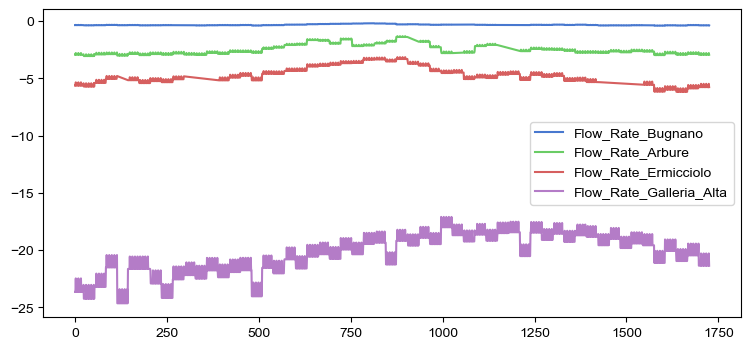

In [103]:
    
# Plot example of filtering out potential anomalies
plt.figure(figsize=(9, 4))
plt.plot(flow_mov_av[1], lw=1, ls='dashed', color=[0, 0, 0, 0.5], label='Moving average')
plt.plot(flow_thresh_hi[1], lw=1, color=[0, 0, 0, 0.5], label='Thresholds')
plt.plot(flow_thresh_lo[1], lw=1, color=[0, 0, 0, 0.5])
plt.plot(target_ts_raw[1], lw=1, color=[0.7, 0.2, 0.2, 0.7], label='Filtered out samples')
plt.plot(target_ts[1], color=[0.2, 0.7, 0.2, 0.7], label='Interpolated', alpha=0.9)
plt.plot(flow_ts_filt[1], label=target_name[n], alpha=0.9)
plt.legend(loc='upper left')
plt.title('Flow rate pre-filtering')
plt.show()

    
# Prob don't need this plot, but kept atm just for reference
plt.figure(figsize=(9, 4))
for n in range(len(target_ts)):
    plt.plot(target_ts[n], label=target_name[n])
plt.legend()
plt.show()

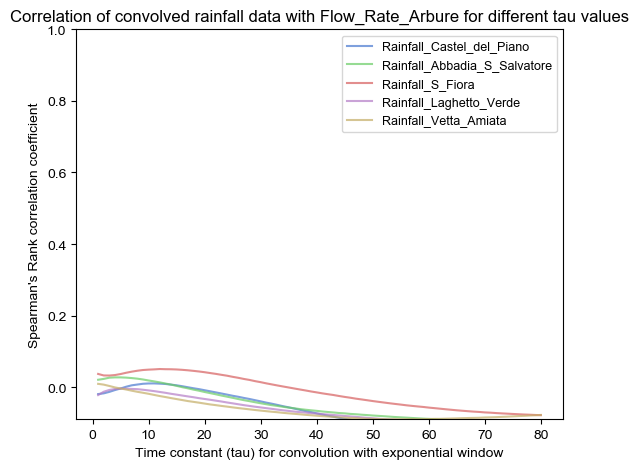

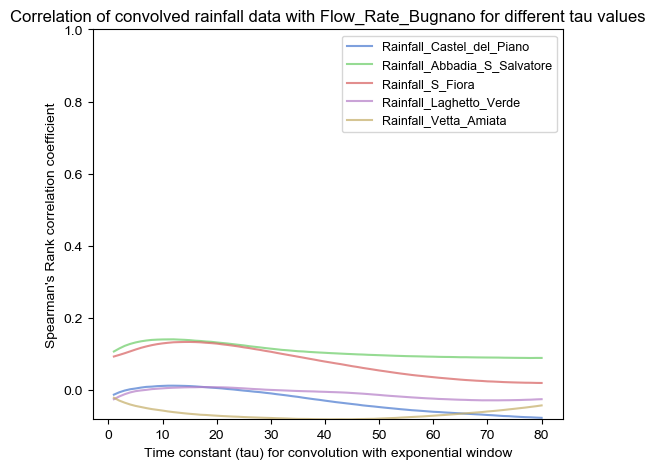

In [104]:
# Plot example of correlation for different tau values

tau_best, src_best = find_best_tau(target_ts=target_ts[0], rain_ts=rain_ts,
                         rain_name=rain_name, plot=True,
                         target_name=target_name[1],
                         tau_array=np.linspace(1, 80, 80))

tau_best, src_best = find_best_tau(target_ts=target_ts[1], rain_ts=rain_ts, plot=True,
                         target_name=target_name[0],
                         rain_name=rain_name,
                         tau_array=np.linspace(1, 80, 80))

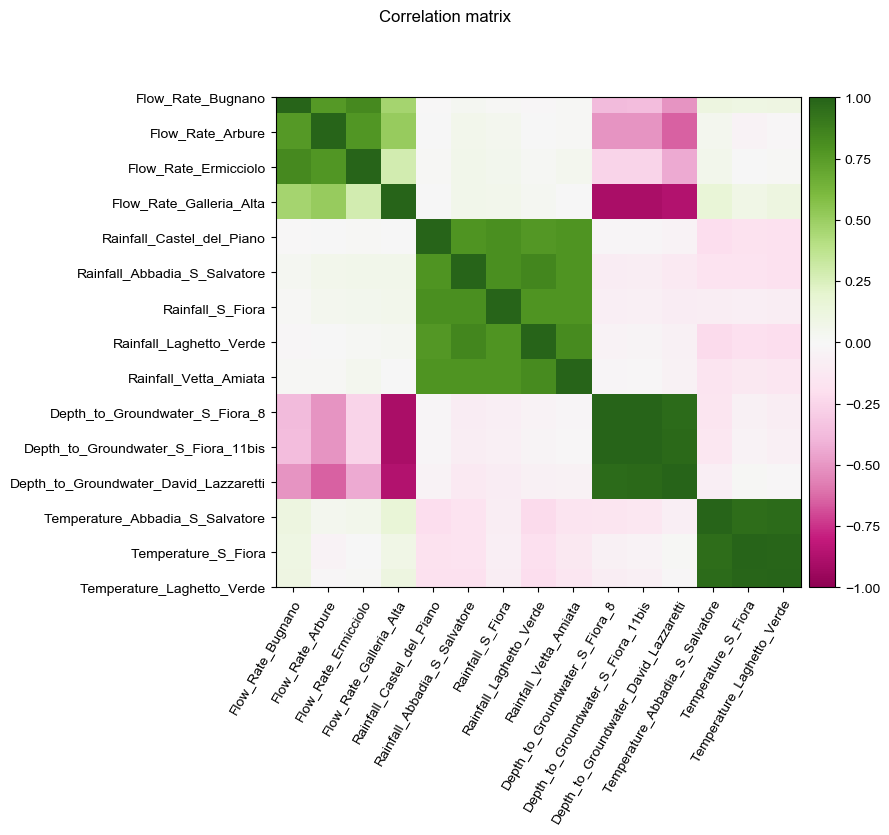

In [105]:

# Combine all pre-processed data
all_data = np.concatenate((np.asarray(target_ts),
                               np.asarray(rain_ts),
                               np.asarray(depth_ts),
                               np.asarray(temp_ts)))
all_name = target_name + rain_name + depth_name + temp_name

# Plot correlation matrices
plot_correl_matrix(all_data, all_name,
                   title='Correlation matrix')


In [106]:

# Better to genralise the earlier function probably

def compile_model_input_variables_spring(model_rain_ind,
                                  model_depth_ind,
                                  model_temp_ind,
                                  rain_pp,
                                  depth_pp,
                                  temp_pp,
                                  num_timesteps):
    """
    Extract the selected variables from the preprocessed data by their indices
    and populate an input array to be used by the model.
    The input array will have shape: (num features, num timesteps)
    
    """    
    num_inputs = len(model_rain_ind) + len(model_depth_ind) + \
                 len(model_temp_ind)
    model_input_data = np.empty((num_inputs, num_timesteps))
    count = 0
    for i in model_rain_ind:
        model_input_data[count, :] = rain_pp[i]
        count += 1
    for i in model_depth_ind:
        model_input_data[count, :] = depth_pp[i]
        count += 1
    for i in model_temp_ind:
        model_input_data[count, :] = temp_pp[i]
        count += 1
    
    return model_input_data

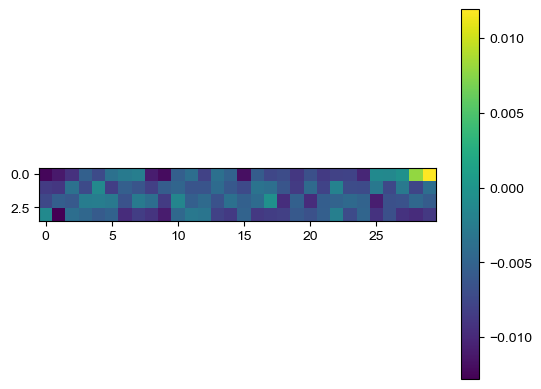

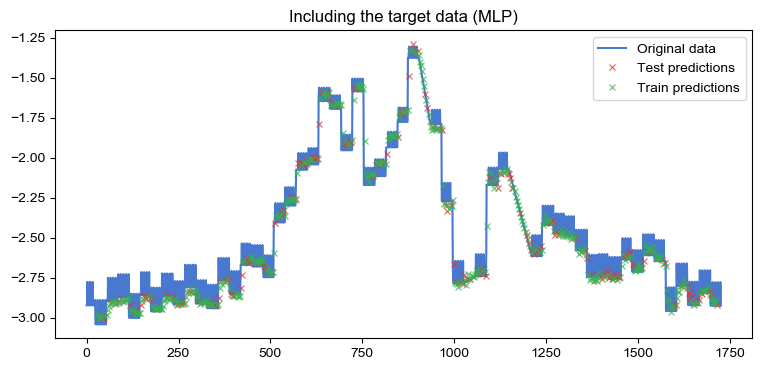

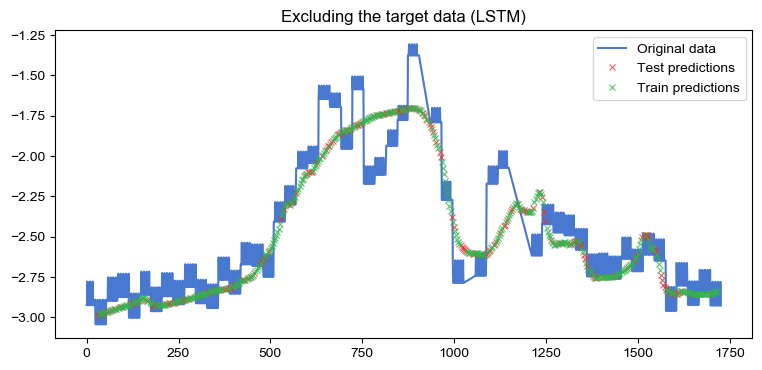

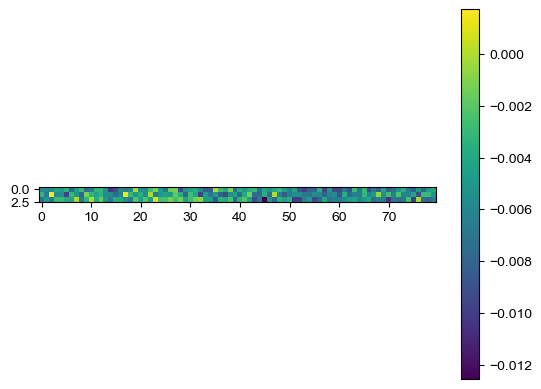

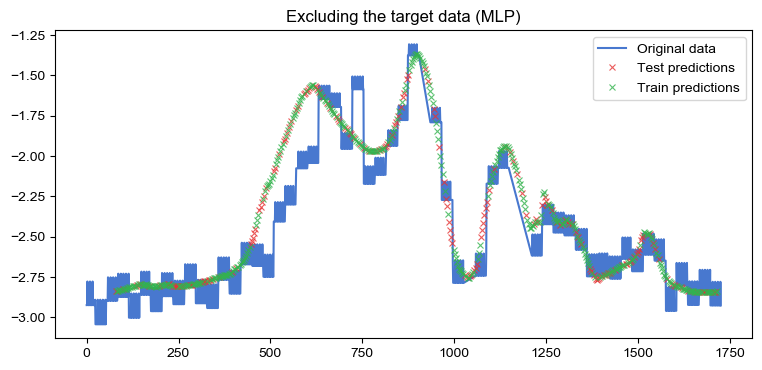

In [107]:
# LSTM with or without target data


# Including the target data 

# Fix random seed for reproducibility
np.random.seed(7)

# Choose variables to include in model by their indices
target_ind = 1
model_rain_ind = []
model_depth_ind = [0, 1, 2]
model_temp_ind = []

# Compile target data and inputs to arrays
target_data = target_ts[target_ind]
model_input_data = compile_model_input_variables_spring(model_rain_ind,
                                                 model_depth_ind,
                                                 model_temp_ind,
                                                 rain_ts,
                                                 depth_ts,
                                                 temp_ts,
                                                 target_ts[target_ind].size)

# Create ML model class and run it
Model_using_target = ML_model(target_data=target_data,
                                input_data=model_input_data,
                                use_target=True,
                                look_back=30,
                                chunk_step=3,
                                train_ratio=0.67,
                                num_epochs=50,
                                batch_size=5,
                                predict_steps=5,
                                plot=False,
                                verbose=0)
Model_using_target.run(model_type='MLP')
layer_1_mean = np.mean(Model_using_target.weights[0], axis=1)
layer_1_mean = layer_1_mean.reshape((Model_using_target.look_back, model_input_data.shape[0] + 1))
plt.figure()
plt.imshow(layer_1_mean.T)
plt.colorbar()
plt.show()
Model_using_target.plot_predict_one_step(title="Including the target data (MLP)")

# Excluding the target data
Model_excluding_target = ML_model(target_data=target_data,
                                input_data=model_input_data,
                                use_target=False,
                                look_back=30,
                                chunk_step=3,
                                train_ratio=0.67,
                                num_epochs=50,
                                batch_size=5,
                                predict_steps=5,
                                plot=False,
                                verbose=0)
Model_excluding_target.run(model_type='LSTM')
Model_excluding_target.plot_predict_one_step(title="Excluding the target data (LSTM)")

# Excluding the target data
Model_excluding_target = ML_model(target_data=target_data,
                                input_data=model_input_data,
                                use_target=False,
                                look_back=80,
                                chunk_step=3,
                                train_ratio=0.67,
                                num_epochs=50,
                                batch_size=5,
                                predict_steps=5,
                                plot=False,
                                verbose=0)
Model_excluding_target.run(model_type='MLP')
layer_1_mean = np.mean(Model_excluding_target.weights[0], axis=1)
layer_1_mean = layer_1_mean.reshape((Model_excluding_target.look_back, model_input_data.shape[0]))
plt.figure()
plt.imshow(layer_1_mean.T)
plt.colorbar()
plt.show()
Model_excluding_target.plot_predict_one_step(title="Excluding the target data (MLP)")


# 4. River Arno

## 4.1 Data pre-processing

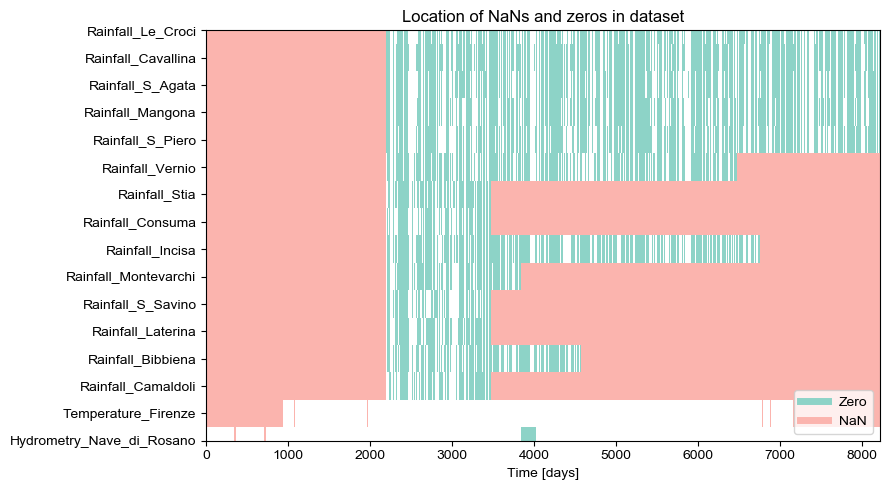

In [108]:
# Pre-processing data

# Importing all data into pandas dataframe
df = pd.read_csv(files[5])

# Find and plot gaps in the data
all_data, col_names, is_nan, is_zero = find_data_gaps(df, plot=True, title=None)

The plot above shows that there is a significant amount of missing data in rainfall. We choose to take data from ~ 2100 - 8300 days and ignore the rainfalls that do not have significant data within that time period. The input features thus include only the first 5 rainfalls and Temperature_Firenze. 

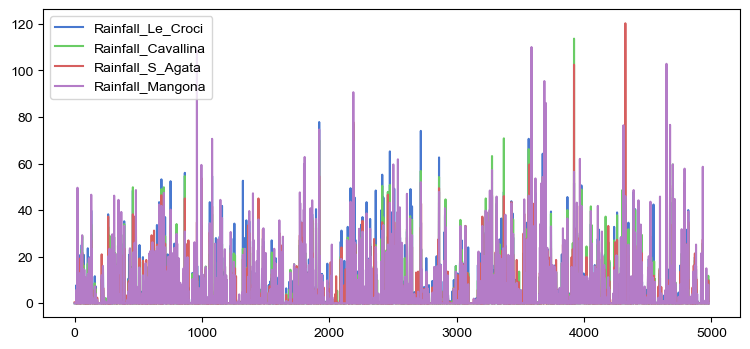

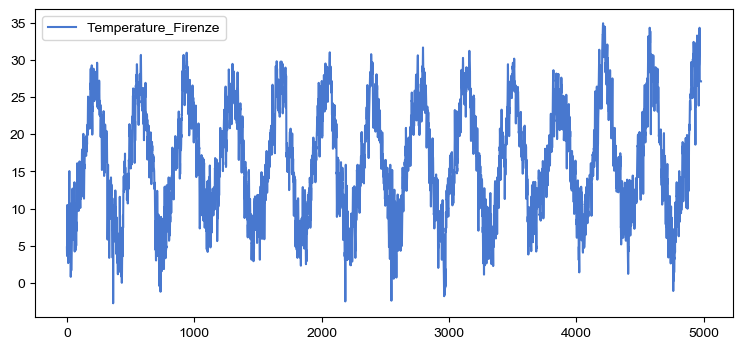

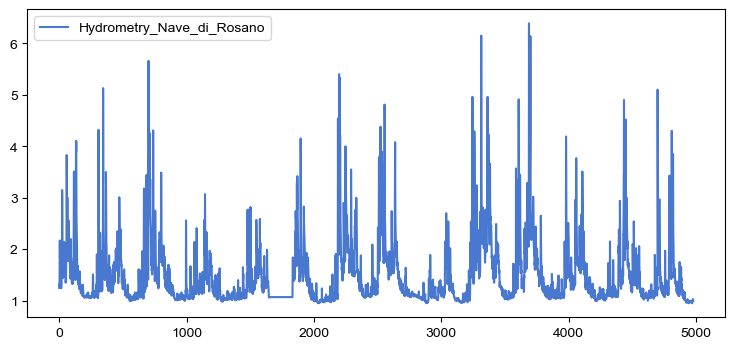

In [109]:
# Find column indices for different datatypes
datatypes, col_inds = find_datatypes(df)

# Get time series data for all variable types
start_ind = 2185
stop_ind = 7165
rain_ts, rain_name = get_time_series(col_inds[0], start_ind=start_ind, stop_ind=stop_ind, fill_zeros=False)
temp_ts, temp_name = get_time_series(col_inds[2], start_ind=start_ind, stop_ind=stop_ind, fill_zeros=True)
target_ts, target_name = get_time_series(col_inds[4], start_ind=start_ind, stop_ind=stop_ind, fill_zeros=True)
# MG: Fill_zeros doesn't seem to be working here...

# Remove zeros and non-zero anomalies from target
# Note - probably not the most efficient method
for m in range(len(target_ts)):
    for n in range(len(target_ts[m])):
        if n > 0 and target_ts[m][n] < 0.6:
            target_ts[m][n] = target_ts[m][n-1]
            
# # Exlcuding irrelevant rainfall datasets
rain_ts = rain_ts[0:4]
rain_name = rain_name[0:4]

plt.figure(figsize=(9, 4))
for n in range(len(rain_ts)):
    plt.plot(rain_ts[n], label=rain_name[n])
plt.legend()
plt.show()

plt.figure(figsize=(9, 4))
for n in range(len(temp_ts)):
    plt.plot(temp_ts[n], label=temp_name[n])
plt.legend()
plt.show()

plt.figure(figsize=(9, 4))
for n in range(len(target_ts)):
    plt.plot(target_ts[n], label=target_name[n])
plt.legend()
plt.show()

The plot above shows that the hydrometry timeseries displays sharp spikes followed by exponential-like decay. This behaviour is reminiscent of the Depth_to_Groundwater data explored for Aquifier Auser at the start of the notebook. We had found that pre-processing the rainfall data with an exponential filter had been effective at drawing correlations between the rainfall and targets, hence we attemp the same method here.

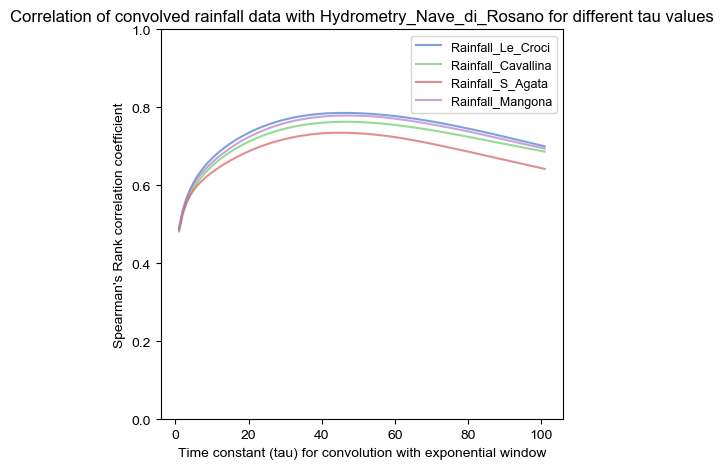

In [110]:
tau_best, src_best = find_best_tau(target_ts=target_ts[0], rain_ts=rain_ts,
                         rain_name=rain_name, plot=True,
                         target_name=target_name[0],
                         tau_array=np.linspace(1, 101, 100))

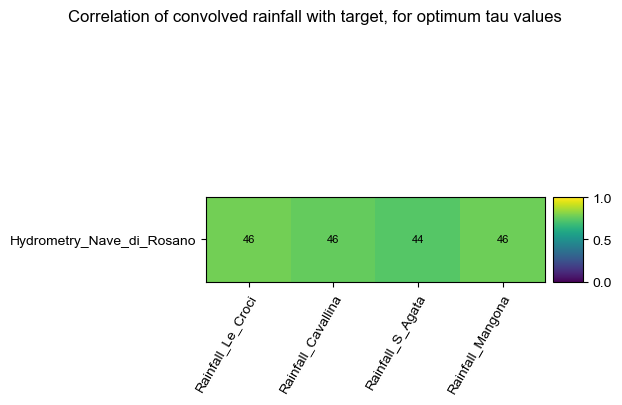

In [111]:
# Calculating optimum tau for each rainfall/target combination that
# maximises the Spearman's Rank correlation coefficient

rain_tau = find_all_best_tau(rain_ts, rain_name, target_ts, target_name,
                            tau_array=np.linspace(1, 101, 100))

In [112]:
rain_filt = rain_ts.copy()
rain_name_pp = rain_name.copy()

# Rainfall data preprocessing
rain_pp_all = []
for n in range(len(rain_filt)):
    rain_pp_ = []
    for m in range(len(target_ts)):
        # tau_ = rain_tau[m, n] # MG: I changed this because rain_tau looks wrong
        tau_ = tau_best[n]
        rain_pp_.append(exp_convolve(rain_filt[n], tau_))
    rain_pp_all.append(rain_pp_)

# Flip the dimensions of the list
rain_pp_all = [list(x) for x in zip(*rain_pp_all)]

# Temperature data preprocessing
temp_pp = temp_ts.copy()
temp_name_pp = temp_name.copy()

In [113]:
# Better to genralise the earlier function probably

def compile_model_input_variables_river(model_rain_ind,
                                  model_temp_ind,
                                  rain_pp,
                                  temp_pp,
                                  num_timesteps):
    """
    Extract the selected variables from the preprocessed data by their indices
    and populate an input array to be used by the model.
    The input array will have shape: (num features, num timesteps)
    
    """    
    num_inputs = len(model_rain_ind) + len(model_temp_ind)
    model_input_data = np.empty((num_inputs, num_timesteps))
    count = 0
    for i in model_rain_ind:
        model_input_data[count, :] = rain_pp[i]
        count += 1
    for i in model_temp_ind:
        model_input_data[count, :] = temp_pp[i]
        count += 1
    
    return model_input_data

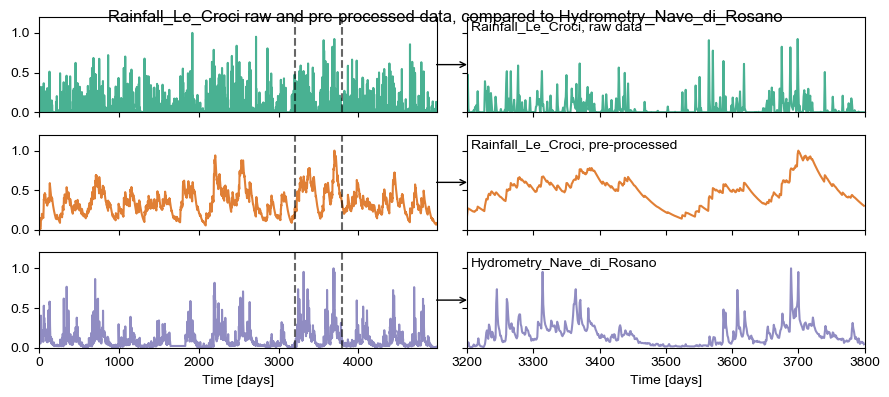

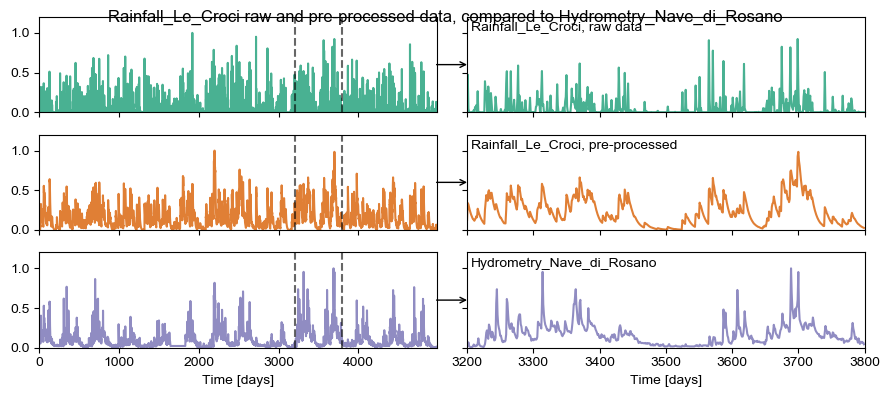

In [114]:
# Rainfall data analysis

r_i = 0
t_i = 0
rain_pp_test = exp_convolve(rain_ts[r_i], tau=rain_tau[t_i, r_i])
#rain_pp_test = rain_pp_all[0][r_i]

plot_preprocessing(rain_ts[r_i], rain_pp_test, rain_name[r_i], target_ts[t_i], target_name[t_i],
                   crop_min=3200, crop_max=3800, title=None)


# Looks like it would be better with tau = ~8, not sure why the correlation is maximised at ~45

rain_pp_test = exp_convolve(rain_ts[r_i], tau=8)
#rain_pp_test = rain_pp_all[0][r_i]

plot_preprocessing(rain_ts[r_i], rain_pp_test, rain_name[r_i], target_ts[t_i], target_name[t_i],
                   crop_min=3200, crop_max=3800, title=None)



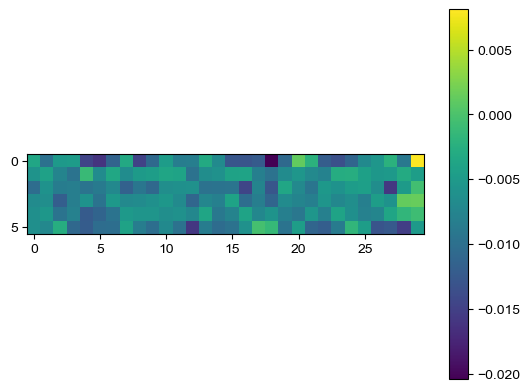

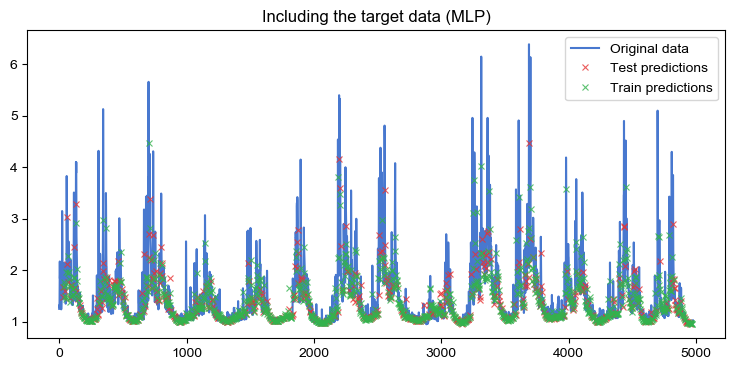

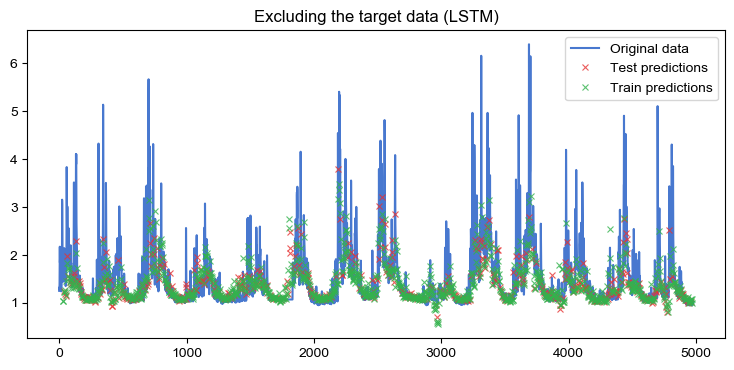

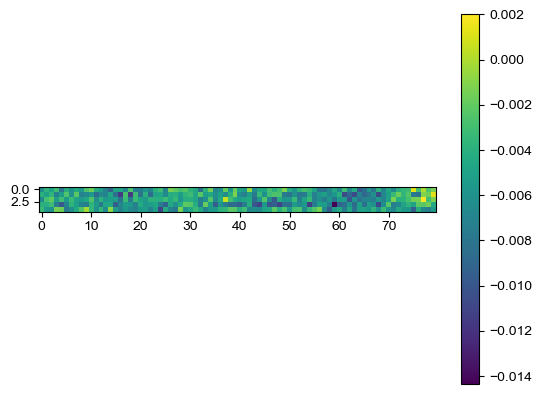

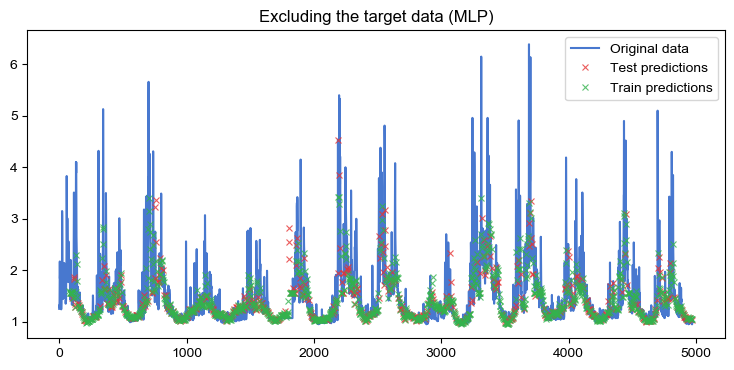

In [115]:
# LSTM with or without target data


# Including the target data 

# Fix random seed for reproducibility
np.random.seed(7)

# Choose variables to include in model by their indices
target_ind = 0
model_rain_ind = [0, 1, 2, 3]
model_temp_ind = [0]

# Compile target data and inputs to arrays
target_data = target_ts[target_ind]
model_input_data = compile_model_input_variables_river(model_rain_ind,
                                                 model_temp_ind,
                                                 rain_pp_all[target_ind],
                                                 temp_pp,
                                                 target_ts[target_ind].size)

# Create ML model class and run it
Model_using_target = ML_model(target_data=target_data,
                                input_data=model_input_data,
                                use_target=True,
                                look_back=30,
                                chunk_step=3,
                                train_ratio=0.67,
                                num_epochs=50,
                                batch_size=5,
                                predict_steps=5,
                                plot=False,
                                verbose=0)
Model_using_target.run(model_type='MLP')
layer_1_mean = np.mean(Model_using_target.weights[0], axis=1)
layer_1_mean = layer_1_mean.reshape((Model_using_target.look_back, model_input_data.shape[0] + 1))
plt.figure()
plt.imshow(layer_1_mean.T)
plt.colorbar()
plt.show()
Model_using_target.plot_predict_one_step(title="Including the target data (MLP)")

# Excluding the target data
Model_excluding_target = ML_model(target_data=target_data,
                                input_data=model_input_data,
                                use_target=False,
                                look_back=30,
                                chunk_step=3,
                                train_ratio=0.67,
                                num_epochs=50,
                                batch_size=5,
                                predict_steps=5,
                                plot=False,
                                verbose=0)
Model_excluding_target.run(model_type='LSTM')
Model_excluding_target.plot_predict_one_step(title="Excluding the target data (LSTM)")

# Excluding the target data
Model_excluding_target = ML_model(target_data=target_data,
                                input_data=model_input_data,
                                use_target=False,
                                look_back=80,
                                chunk_step=3,
                                train_ratio=0.67,
                                num_epochs=70,
                                batch_size=5,
                                predict_steps=5,
                                plot=False,
                                verbose=0)
Model_excluding_target.run(model_type='MLP')
layer_1_mean = np.mean(Model_excluding_target.weights[0], axis=1)
layer_1_mean = layer_1_mean.reshape((Model_excluding_target.look_back, model_input_data.shape[0]))
plt.figure()
plt.imshow(layer_1_mean.T)
plt.colorbar()
plt.show()
Model_excluding_target.plot_predict_one_step(title="Excluding the target data (MLP)")


# 5. Lake Bilancino

## 5.1 Data pre-processing

### 5.1.1 Data availability

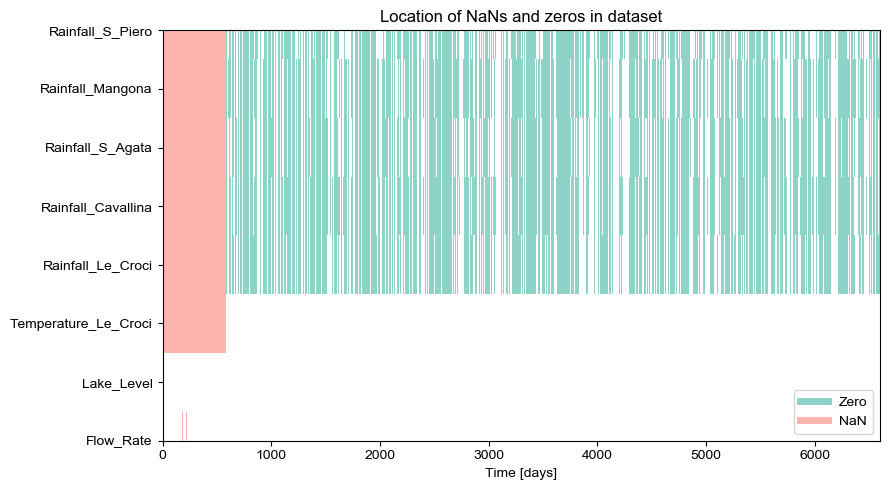

In [116]:
# Pre-processing data

# Importing all data into pandas dataframe
df = pd.read_csv(files[4])

# Find and plot gaps in the data
all_data, col_names, is_nan, is_zero = find_data_gaps(df, plot=True, title=None)

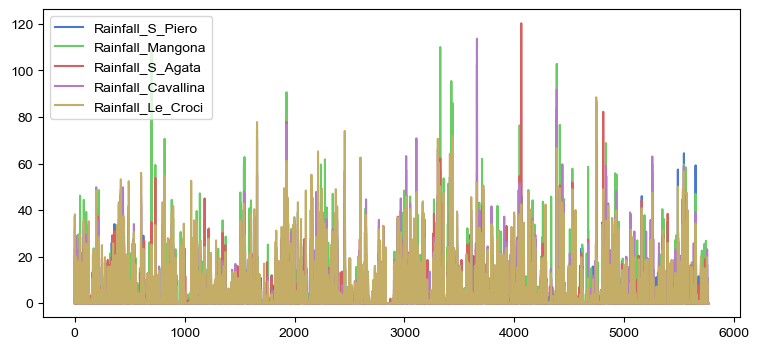

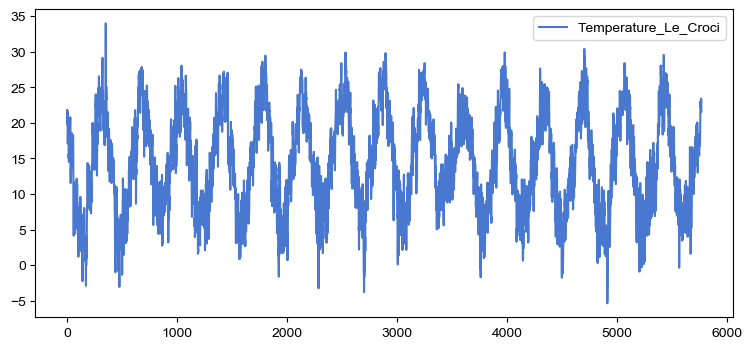

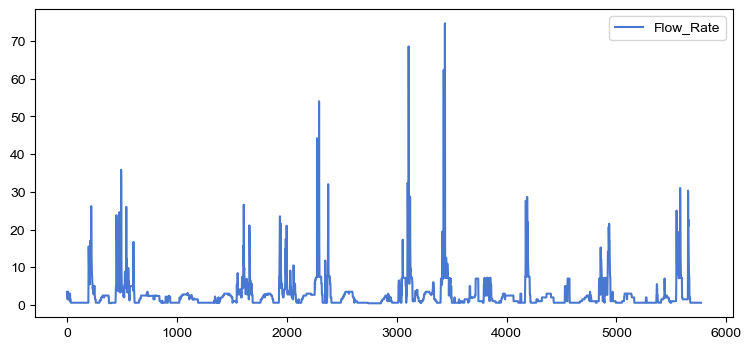

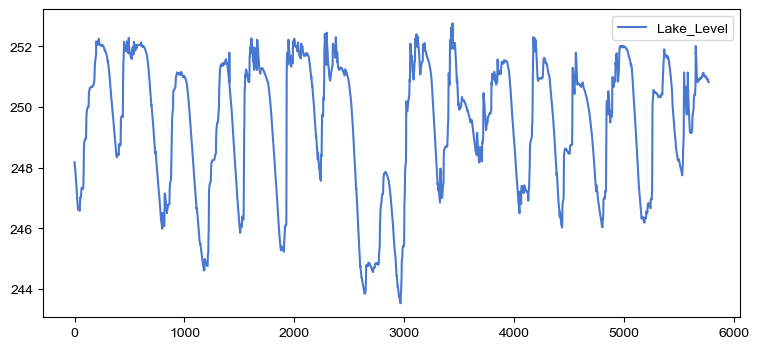

In [117]:
# Find column indices for different datatypes
datatypes, col_inds = find_datatypes(df)

# Get time series data for all variable types
start_ind = 832
rain_ts, rain_name = get_time_series(col_inds[0], start_ind=start_ind, fill_zeros=False)
temp_ts, temp_name = get_time_series(col_inds[2], start_ind=start_ind, fill_zeros=True)
target_ts1, target_name1 = get_time_series(col_inds[5], start_ind=start_ind, fill_zeros=True)
target_ts2, target_name2 = get_time_series(col_inds[6], start_ind=start_ind, fill_zeros=True)
target_ts = target_ts1 + target_ts2
target_name = target_name1 + target_name2 

plt.figure(figsize=(9, 4))
for n in range(len(rain_ts)):
    plt.plot(rain_ts[n], label=rain_name[n])
plt.legend()
plt.show()

plt.figure(figsize=(9, 4))
for n in range(len(temp_ts)):
    plt.plot(temp_ts[n], label=temp_name[n])
plt.legend()
plt.show()

plt.figure(figsize=(9, 4))
plt.plot(target_ts[0], label=target_name[0])
plt.legend()
plt.show()

plt.figure(figsize=(9, 4))
plt.plot(target_ts[1], label=target_name[1])
plt.legend()
plt.show()

### 5.1.2 Rainfall analysis

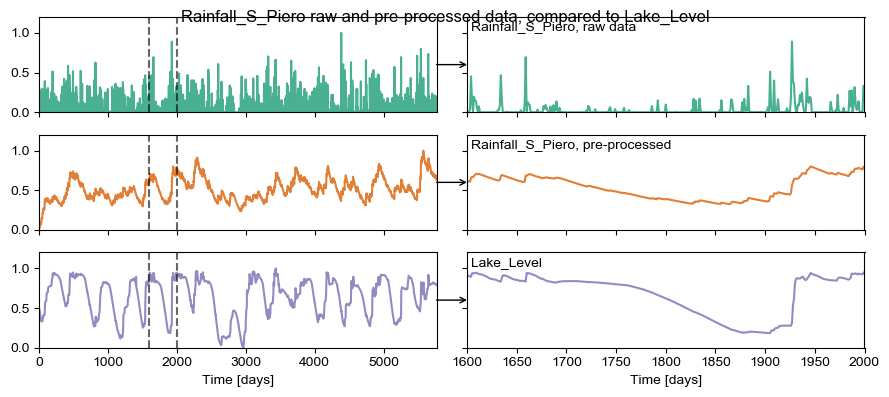

In [118]:
# Rainfall data analysis

r_i = 0
t_i = 1
rain_pp_test = exp_convolve(rain_ts[r_i], tau=150)
#rain_pp_test = rain_pp_all[0][r_i]

plot_preprocessing(rain_ts[r_i], rain_pp_test, rain_name[r_i], target_ts[t_i], target_name[t_i],
                   crop_min=1600, crop_max=2000, title=None)

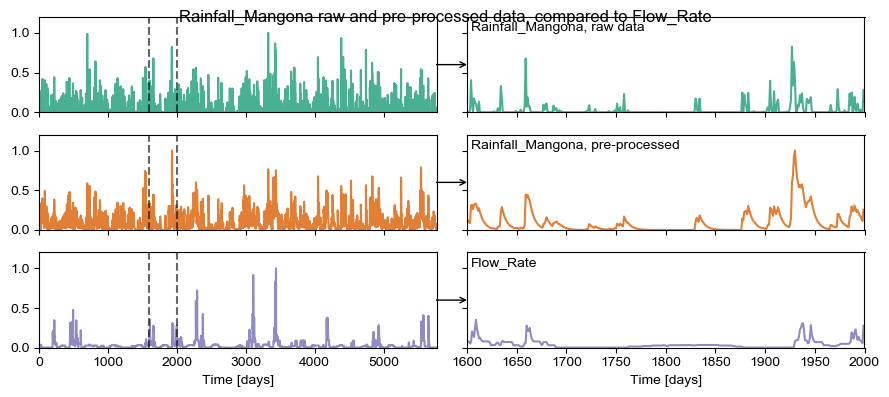

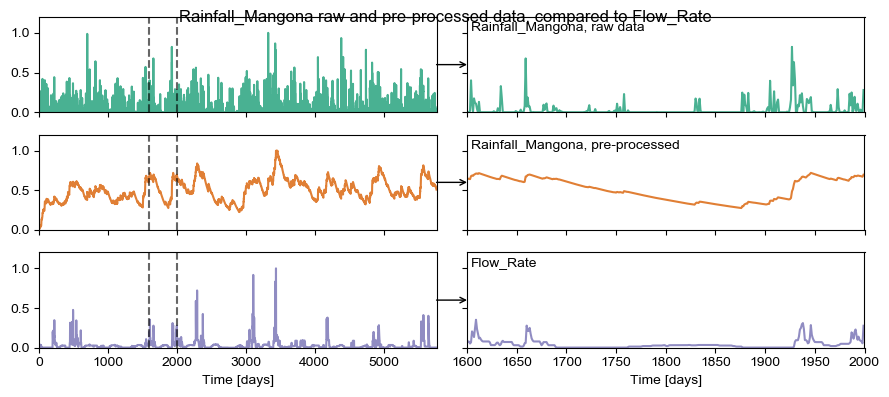

In [119]:
# Rainfall data analysis

r_i = 1
t_i = 0
rain_pp_test = exp_convolve(rain_ts[r_i], tau=5)
#rain_pp_test = rain_pp_all[0][r_i]

plot_preprocessing(rain_ts[r_i], rain_pp_test, rain_name[r_i], target_ts[t_i], target_name[t_i],
                   crop_min=1600, crop_max=2000, title=None)


r_i = 1
t_i = 0
rain_pp_test = exp_convolve(rain_ts[r_i], tau=163)
#rain_pp_test = rain_pp_all[0][r_i]

plot_preprocessing(rain_ts[r_i], rain_pp_test, rain_name[r_i], target_ts[t_i], target_name[t_i],
                   crop_min=1600, crop_max=2000, title=None)

# Looks like tau = 5 is much better than the supposed 'max correlation' tau=163, not sure why?
# There's a double peak in the 'find_best_tau' plot, and the first peak around tau = ~5 seems
# more sensible than the peak at tau = ~160

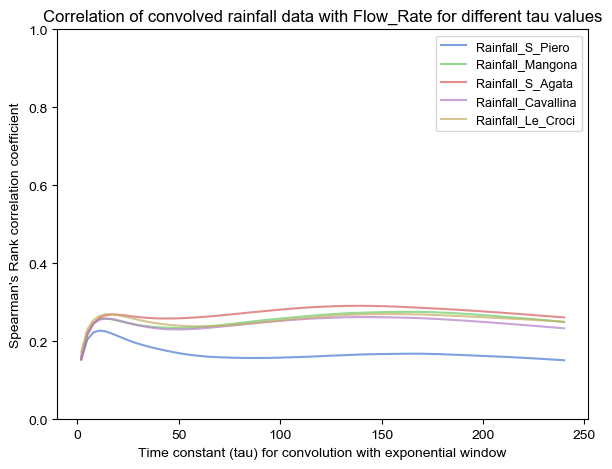

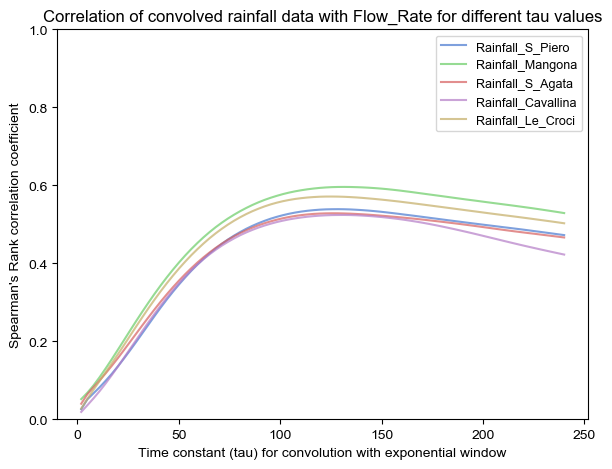

In [120]:
tau_best, src_best = find_best_tau(target_ts=target_ts[0], rain_ts=rain_ts,
                         rain_name=rain_name, plot=True,
                         target_name=target_name[0],
                         tau_array=np.linspace(2, 240, 80))

tau_best, src_best = find_best_tau(target_ts=target_ts[1], rain_ts=rain_ts,
                         rain_name=rain_name, plot=True,
                         target_name=target_name[0],
                         tau_array=np.linspace(2, 240, 80))

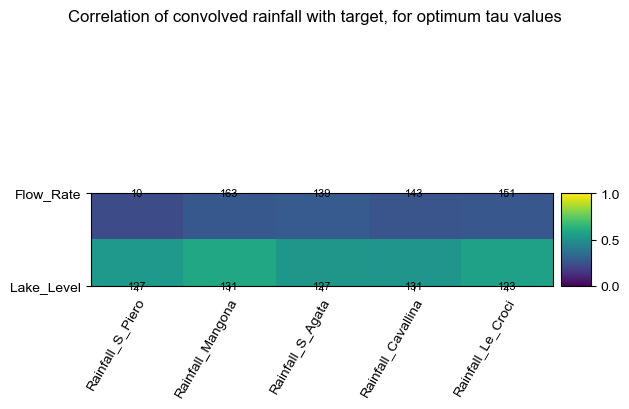

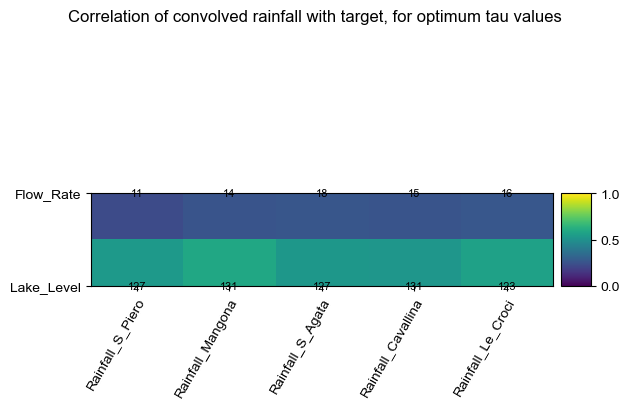

In [121]:
# Calculating optimum tau for each rainfall/target combination that
# maximises the Spearman's Rank correlation coefficient

rain_tau = find_all_best_tau(rain_ts, rain_name, target_ts, target_name,
                             tau_array=np.linspace(2, 200, 50))

# Changed tau test range to avoid later peaks at ~tau=160 for first target
# Not sure what the explanation is for correlation being higher at tau=160
# but it seems more sensible to pick the peak at tau = ~5 as it seems visually better
rain_tau = find_all_best_tau(rain_ts, rain_name, target_ts, target_name,
                             tau_array=np.linspace(2, 200, 50),
                             target_0_tau_array=np.linspace(1, 50, 50))
# MG: Again seems like the tau's reported below are wrong...

In [122]:
rain_filt = rain_ts.copy()
rain_name_pp = rain_name.copy()

# Rainfall data preprocessing
rain_pp_all = []
for n in range(len(rain_filt)):
    rain_pp_ = []
    for m in range(len(target_ts)):
        tau_ = rain_tau[m, n]
        rain_pp_.append(exp_convolve(rain_filt[n], tau_))
    rain_pp_all.append(rain_pp_)

# Flip the dimensions of the list
rain_pp_all = [list(x) for x in zip(*rain_pp_all)]

# Temperature data preprocessing
temp_pp = temp_ts.copy()
temp_name_pp = temp_name.copy()

In [123]:
# Better to genralise the earlier function probably

def compile_model_input_variables_lake(model_rain_ind,
                                  model_temp_ind,
                                  rain_pp,
                                  temp_pp,
                                  num_timesteps):
    """
    Extract the selected variables from the preprocessed data by their indices
    and populate an input array to be used by the model.
    The input array will have shape: (num features, num timesteps)
    
    """    
    num_inputs = len(model_rain_ind) + len(model_temp_ind)
    model_input_data = np.empty((num_inputs, num_timesteps))
    count = 0
    for i in model_rain_ind:
        model_input_data[count, :] = rain_pp[i]
        count += 1
    for i in model_temp_ind:
        model_input_data[count, :] = temp_pp[i]
        count += 1
    
    return model_input_data

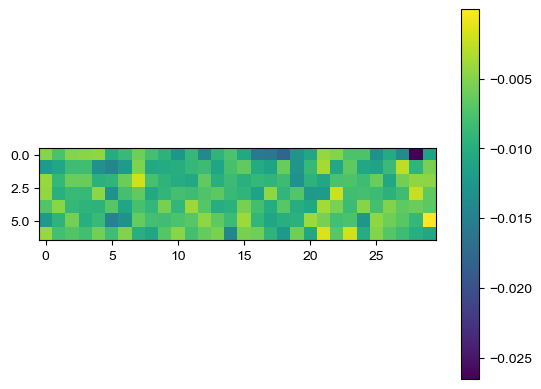

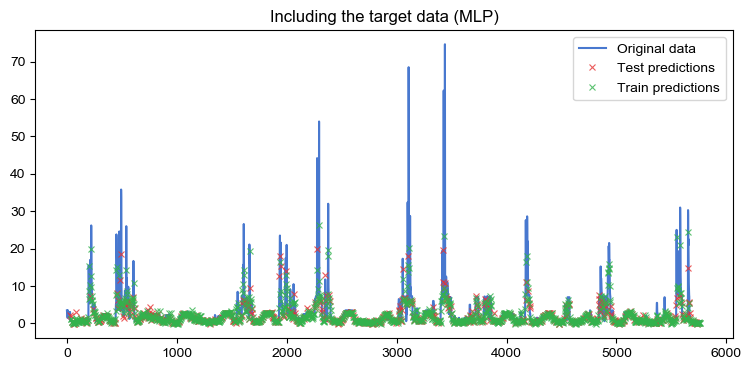

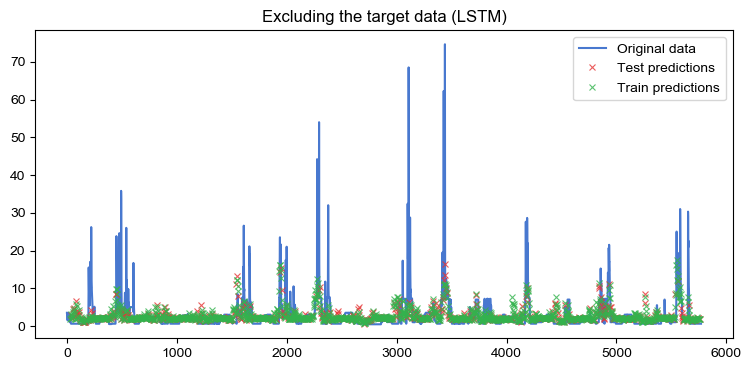

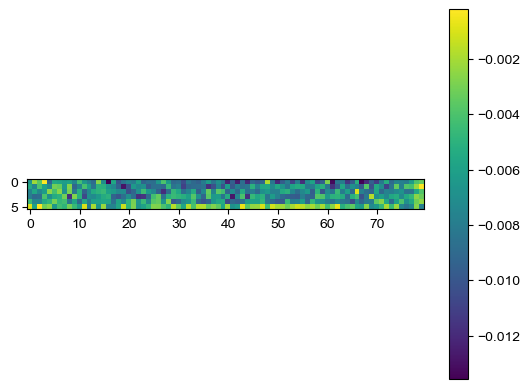

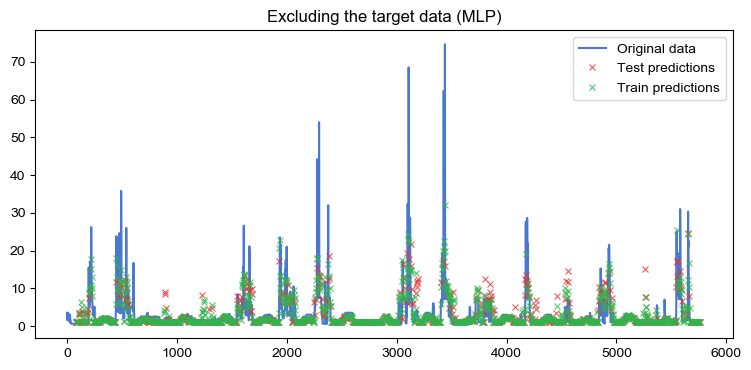

In [124]:
# LSTM with or without target data


# Including the target data 

# Fix random seed for reproducibility
np.random.seed(7)

# Choose variables to include in model by their indices
target_ind = 0
model_rain_ind = [0, 1, 2, 3, 4]
model_temp_ind = [0]

# Compile target data and inputs to arrays
target_data = target_ts[target_ind]
model_input_data = compile_model_input_variables_lake(model_rain_ind,
                                                 model_temp_ind,
                                                 rain_pp_all[target_ind],
                                                 temp_pp,
                                                 target_ts[target_ind].size)

# Create ML model class and run it
Model_using_target = ML_model(target_data=target_data,
                                input_data=model_input_data,
                                use_target=True,
                                look_back=30,
                                chunk_step=3,
                                train_ratio=0.67,
                                num_epochs=50,
                                batch_size=5,
                                predict_steps=5,
                                plot=False,
                                verbose=0)
Model_using_target.run(model_type='MLP')
layer_1_mean = np.mean(Model_using_target.weights[0], axis=1)
layer_1_mean = layer_1_mean.reshape((Model_using_target.look_back, model_input_data.shape[0] + 1))
plt.figure()
plt.imshow(layer_1_mean.T)
plt.colorbar()
plt.show()
Model_using_target.plot_predict_one_step(title="Including the target data (MLP)")

# Excluding the target data
Model_excluding_target = ML_model(target_data=target_data,
                                input_data=model_input_data,
                                use_target=False,
                                look_back=30,
                                chunk_step=3,
                                train_ratio=0.67,
                                num_epochs=50,
                                batch_size=5,
                                predict_steps=5,
                                plot=False,
                                verbose=0)
Model_excluding_target.run(model_type='LSTM')
Model_excluding_target.plot_predict_one_step(title="Excluding the target data (LSTM)")

# Excluding the target data
Model_excluding_target = ML_model(target_data=target_data,
                                input_data=model_input_data,
                                use_target=False,
                                look_back=80,
                                chunk_step=3,
                                train_ratio=0.67,
                                num_epochs=70,
                                batch_size=5,
                                predict_steps=5,
                                plot=False,
                                verbose=0)
Model_excluding_target.run(model_type='MLP')
layer_1_mean = np.mean(Model_excluding_target.weights[0], axis=1)
layer_1_mean = layer_1_mean.reshape((Model_excluding_target.look_back, model_input_data.shape[0]))
plt.figure()
plt.imshow(layer_1_mean.T)
plt.colorbar()
plt.show()
Model_excluding_target.plot_predict_one_step(title="Excluding the target data (MLP)")


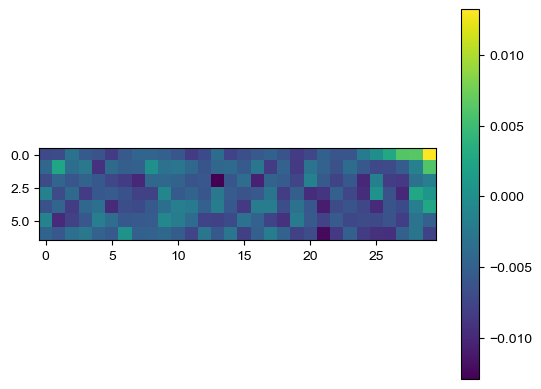

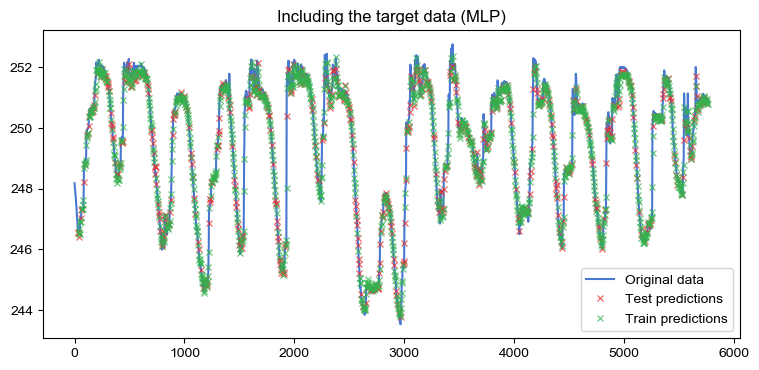

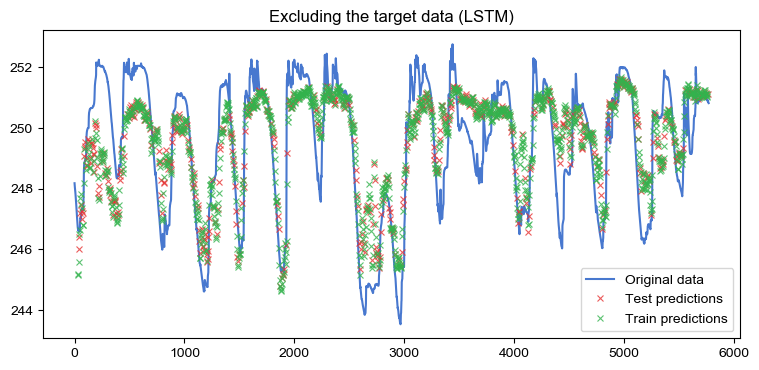

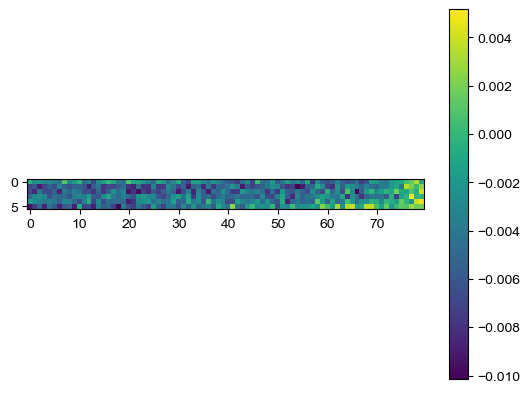

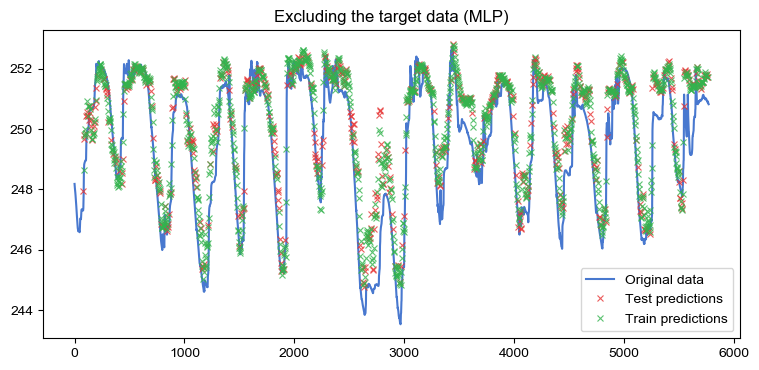

In [125]:
# LSTM with or without target data


# Including the target data 

# Fix random seed for reproducibility
np.random.seed(7)

# Choose variables to include in model by their indices
target_ind = 1
model_rain_ind = [0, 1, 2, 3, 4]
model_temp_ind = [0]

# Compile target data and inputs to arrays
target_data = target_ts[target_ind]
model_input_data = compile_model_input_variables_lake(model_rain_ind,
                                                 model_temp_ind,
                                                 rain_pp_all[target_ind],
                                                 temp_pp,
                                                 target_ts[target_ind].size)

# Create ML model class and run it
Model_using_target = ML_model(target_data=target_data,
                                input_data=model_input_data,
                                use_target=True,
                                look_back=30,
                                chunk_step=3,
                                train_ratio=0.67,
                                num_epochs=50,
                                batch_size=5,
                                predict_steps=5,
                                plot=False,
                                verbose=0)
Model_using_target.run(model_type='MLP')
layer_1_mean = np.mean(Model_using_target.weights[0], axis=1)
layer_1_mean = layer_1_mean.reshape((Model_using_target.look_back, model_input_data.shape[0] + 1))
plt.figure()
plt.imshow(layer_1_mean.T)
plt.colorbar()
plt.show()
Model_using_target.plot_predict_one_step(title="Including the target data (MLP)")

# Excluding the target data
Model_excluding_target = ML_model(target_data=target_data,
                                input_data=model_input_data,
                                use_target=False,
                                look_back=30,
                                chunk_step=3,
                                train_ratio=0.67,
                                num_epochs=50,
                                batch_size=5,
                                predict_steps=5,
                                plot=False,
                                verbose=0)
Model_excluding_target.run(model_type='LSTM')
Model_excluding_target.plot_predict_one_step(title="Excluding the target data (LSTM)")

# Excluding the target data
Model_excluding_target = ML_model(target_data=target_data,
                                input_data=model_input_data,
                                use_target=False,
                                look_back=80,
                                chunk_step=3,
                                train_ratio=0.67,
                                num_epochs=70,
                                batch_size=5,
                                predict_steps=5,
                                plot=False,
                                verbose=0)
Model_excluding_target.run(model_type='MLP')
layer_1_mean = np.mean(Model_excluding_target.weights[0], axis=1)
layer_1_mean = layer_1_mean.reshape((Model_excluding_target.look_back, model_input_data.shape[0]))
plt.figure()
plt.imshow(layer_1_mean.T)
plt.colorbar()
plt.show()
Model_excluding_target.plot_predict_one_step(title="Excluding the target data (MLP)")
